In [10]:
import pickle
import spike.spike_analysis.spike_collection as sc
import spike.spike_analysis.pca_trajectories as pca_trajectories
import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.spike_recording as sr
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import sem
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import matplotlib.patches as mpatches
from itertools import combinations
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import seaborn as sns
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold'

def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))
    


In [3]:

def plot_pca_results_3d(pca_result, title, colors, azim, elev, save = False):
    event_lengths = int(
            (pca_result.event_length + pca_result.pre_window + pca_result.post_window) * 1000 / pca_result.timebin
        )
    
    event_end = int((pca_result.event_length + pca_result.pre_window) * 1000 / pca_result.timebin)
    pre_window = pca_result.pre_window * 1000 / pca_result.timebin
    post_window = pca_result.post_window * 1000 / pca_result.timebin
    pc_var = pca_result.explained_variance
    PCA_key = pca_result.labels
    PCA_matrix = pca_result.transformed_data
    col_counter = 0
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection="3d")
    #plt.subplots_adjust(left=0.3, right=0.99, bottom=0.1, top=0.9)
    for i in range(0, len(PCA_key), event_lengths):
        event_label = PCA_key[i]
        onset = int(i + pre_window - 1)
        end = int(i + event_end - 1)
        post = int(i + event_lengths - 1)
        ax.plot3D(
            PCA_matrix[i : i + event_lengths, 0],
            PCA_matrix[i : i + event_lengths, 1],
            PCA_matrix[i : i + event_lengths, 2],
            label=event_label,
            color=colors[col_counter],
            linewidth = 5,
            alpha = 0.8
        )
        ax.scatter(
            PCA_matrix[i, 0],
            PCA_matrix[i, 1],
            PCA_matrix[i, 2],
            marker="s",
            s=100,
            c="w",
            edgecolors=colors[col_counter],
        )
        ax.scatter(
            PCA_matrix[onset, 0],
            PCA_matrix[onset, 1],
            PCA_matrix[onset, 2],
            marker="^",
            s=300,
            c="w",
            edgecolors=colors[col_counter],
        )
        ax.scatter(
            PCA_matrix[end, 0],
            PCA_matrix[end, 1],
            PCA_matrix[end, 2],
            marker="o",
            s=200,
            c="w",
            edgecolors=colors[col_counter],
        )
        if post_window != 0:
            ax.scatter(
                PCA_matrix[post, 0],
                PCA_matrix[post, 1],
                PCA_matrix[post, 2],
                marker="D",
                s=200,
                c="w",
                edgecolors=colors[col_counter],
            )
        col_counter += 1
    ax.legend(loc="upper left", bbox_to_anchor=(.9,1), frameon = False, fontsize = 14)
    # ax.set_xlim(-20, 45)
    # ax.set_ylim(-5, 25)
    # ax.set_zlim(-20, 30)
    ax.view_init(azim = azim, elev =elev)
    ax.set_title(f"{title}", fontsize = 24, y = 1)
    ax.set_xlabel(f"PC1 ({pc_var[0]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_ylabel(f"PC2 ({pc_var[1]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_zlabel(f"PC3 ({pc_var[2]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.yaxis.pane.set_alpha(0.9)
    ax.xaxis.pane.set_alpha(0.9)
    ax.zaxis.pane.set_alpha(0.9)
    plt.tight_layout()
    if save:
        plt.savefig(f'{title}.png', dpi = 600, transparent = True,bbox_inches='tight' )
    plt.show()


def plot_pca_results_2d(pca_result, title, colors, legend_spot, save=False):
    event_lengths = int(
        (pca_result.event_length + pca_result.pre_window + pca_result.post_window) * 1000 / pca_result.timebin
    )
    
    event_end = int((pca_result.event_length + pca_result.pre_window) * 1000 / pca_result.timebin)
    pre_window = pca_result.pre_window * 1000 / pca_result.timebin
    post_window = pca_result.post_window * 1000 / pca_result.timebin
    pc_var = pca_result.explained_variance
    PCA_key = pca_result.labels
    PCA_matrix = pca_result.transformed_data
    col_counter = 0
    
    # Create figure with updated size
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    
    for i in range(0, len(PCA_key), event_lengths):
        event_label = PCA_key[i]
        onset = int(i + pre_window - 1)
        end = int(i + event_end - 1)
        post = int(i + event_lengths - 1)
        
        # Plot the continuous line with updated styling
        ax.plot(
            PCA_matrix[i:i + event_lengths, 0],
            PCA_matrix[i:i + event_lengths, 1],
            label=event_label,
            color=colors[col_counter],
            linewidth=5,
            alpha=0.8,
            zorder = 1
        )
        
        # Add markers with updated sizes
        ax.scatter(
            PCA_matrix[i, 0],
            PCA_matrix[i, 1],
            marker="s",
            s=200,
            c="w",
            edgecolors=colors[col_counter],
            zorder = 2
        )
        ax.scatter(
            PCA_matrix[onset, 0],
            PCA_matrix[onset, 1],
            marker="^",
            s=300,
            c="w",
            edgecolors=colors[col_counter],
            zorder = 3
        )
        ax.scatter(
            PCA_matrix[end, 0],
            PCA_matrix[end, 1],
            marker="o",
            s=200,
            c="w",
            edgecolors=colors[col_counter],
            zorder = 4
        )
        if post_window != 0:
            ax.scatter(
                PCA_matrix[post, 0],
                PCA_matrix[post, 1],
                marker="D",
                s=200,
                c="w",
                edgecolors=colors[col_counter],
                zorder =5
            )
        col_counter += 1
    
    # Updated legend formatting
    ax.legend(loc="upper left", bbox_to_anchor=legend_spot, frameon=False, fontsize=14)
    
    # ax.set_xlim(-20, 45)
    # ax.set_ylim(-5, 25)
    
    # Updated title and label formatting
    ax.set_title(f"{title}", fontsize=24, y=1.01)
    ax.set_xlabel(f"PC1 ({pc_var[0]*100:.1f}% variance)", fontsize=16)
    ax.set_ylabel(f"PC2 ({pc_var[1]*100:.1f}% variance)", fontsize=16)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    
    # Add tight layout
    plt.tight_layout()
    
    if save:
        plt.savefig(f'{title}.png', dpi=600, transparent=True, bbox_inches='tight')
    plt.show()

In [4]:
novel_collection = sc.SpikeCollection.load_collection('pilot2/habit_dishabit_phase1/novel_collection/spike_collection.json')
cagemate_collection = sc.SpikeCollection.load_collection('pilot2/habit_dishabit_phase1/cagemate_collection/spike_collection.json')




In [5]:
cagemate_collection.analyze(timebin = 100, ignore_freq=0.5, smoothing_window=500)
novel_collection.analyze(timebin = 100, ignore_freq=0.5, smoothing_window=500)

All set to analyze
All set to analyze


In [6]:
color_id_dict = {'novel': hex_2_rgb('#15616F'), 
                    'short-term familiar': (1.0, 0.6862745098039216, 0.0),
                    'long-term familiar': hex_2_rgb('#792910')}

In [8]:
cagemate_collection.recordings[0].event_dict.keys()

dict_keys(['aversive', 'baseline', 'exp1 allogroom', 'exp1 aversive', 'exp1 chase', 'exp1 fight', 'exp1 positive', 'exp1 sniff', 'exp2 allogroom', 'exp2 aversive', 'exp2 chase', 'exp2 fight', 'exp2 positive', 'exp2 sniff', 'exp3 allogroom', 'exp3 aversive', 'exp3 chase', 'exp3 fight', 'exp3 positive', 'exp3 sniff', 'exp4 allogroom', 'exp4 aversive', 'exp4 chase', 'exp4 fight', 'exp4 positive', 'exp4 sniff', 'exp5 allogroom', 'exp5 aversive', 'exp5 chase', 'exp5 fight', 'exp5 positive', 'exp5 sniff', 'positive'])

In [24]:
cagemate_collection.analyze(timebin = 100, ignore_freq=0.5, smoothing_window=250)
novel_collection.analyze(timebin = 100, ignore_freq=0.5, smoothing_window=250)

All set to analyze
All set to analyze


Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


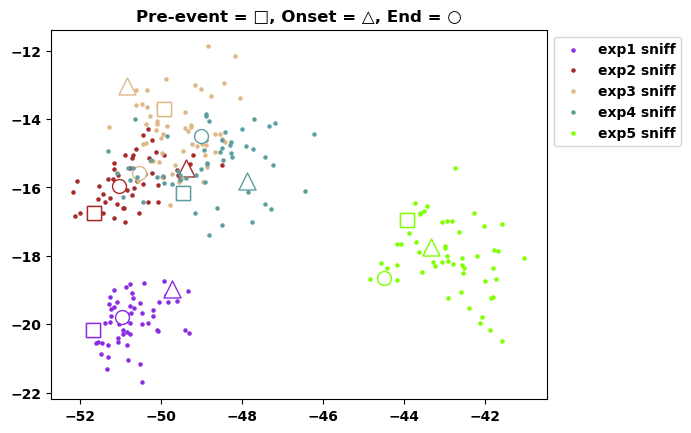

Excluding 33_nov_p1_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


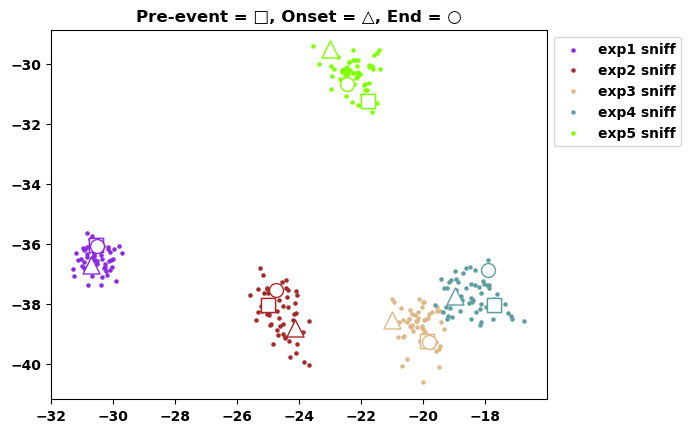

C:\Users\megha\AppData\Local\Temp\ipykernel_28176\677874798.py:83: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


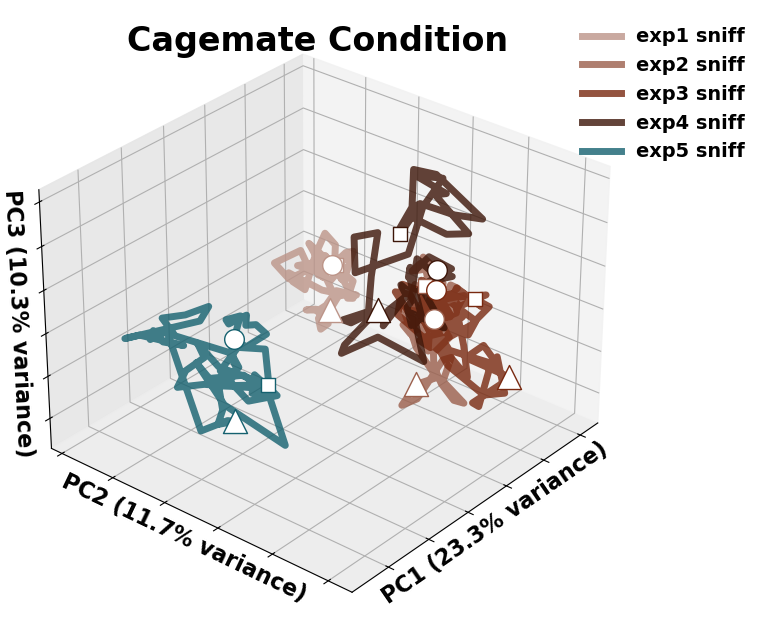

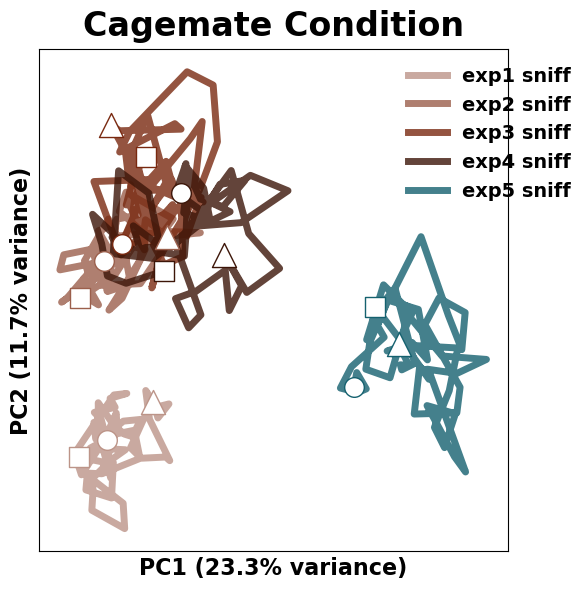

C:\Users\megha\AppData\Local\Temp\ipykernel_28176\677874798.py:83: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


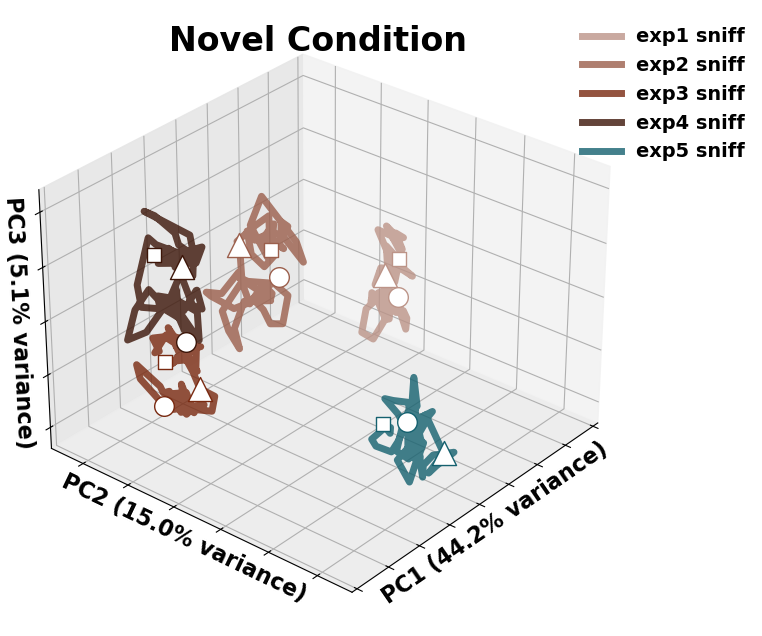

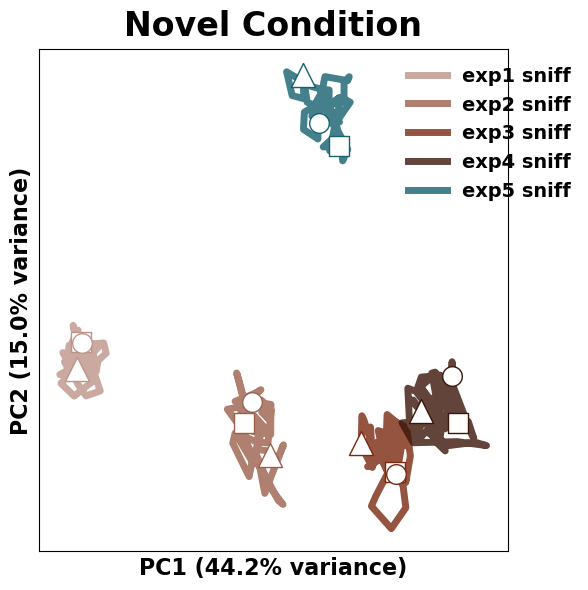

PCA Result with:
Events: exp1 sniff, exp2 sniff, exp3 sniff, exp4 sniff, exp5 sniff
Timebins per event: 60.0
Total neurons: 131
Number of recordings: 9
Number of Pcs needed to explain 90% of variance 25
PCA Result with:
Events: exp1 sniff, exp2 sniff, exp3 sniff, exp4 sniff, exp5 sniff
Timebins per event: 60.0
Total neurons: 130
Number of recordings: 9
Number of Pcs needed to explain 90% of variance 25


In [25]:
import importlib
importlib.reload(pca_trajectories)
cagemate_pca_results = pca_trajectories.avg_trajectories_pca(cagemate_collection, 3, 3, events = ['exp1 sniff', 'exp2 sniff', 'exp3 sniff', 'exp4 sniff', 'exp5 sniff'],min_neurons=5, plot = True)
novel_pca_results = pca_trajectories.avg_trajectories_pca(novel_collection, 3, 3, events = ['exp1 sniff', 'exp2 sniff', 'exp3 sniff', 'exp4 sniff', 'exp5 sniff'],min_neurons=5, plot = True)

expsniffcolors = [hex_2_rgb('#bc9488'),
              hex_2_rgb('#9b5f4c'),
              hex_2_rgb('#792910'),
              hex_2_rgb('#3c1508'),
              hex_2_rgb('#15616F')]
plot_pca_results_3d(cagemate_pca_results, "Cagemate Condition", expsniffcolors, azim = 40, elev = 30)
plot_pca_results_2d(cagemate_pca_results, "Cagemate Condition", colors = expsniffcolors, legend_spot = (0.75, 1))
plot_pca_results_3d(novel_pca_results, "Novel Condition", expsniffcolors, azim = 40, elev = 30)
plot_pca_results_2d(novel_pca_results, "Novel Condition", colors = expsniffcolors, legend_spot = (0.75, 1))
print(cagemate_pca_results)
print(novel_pca_results)


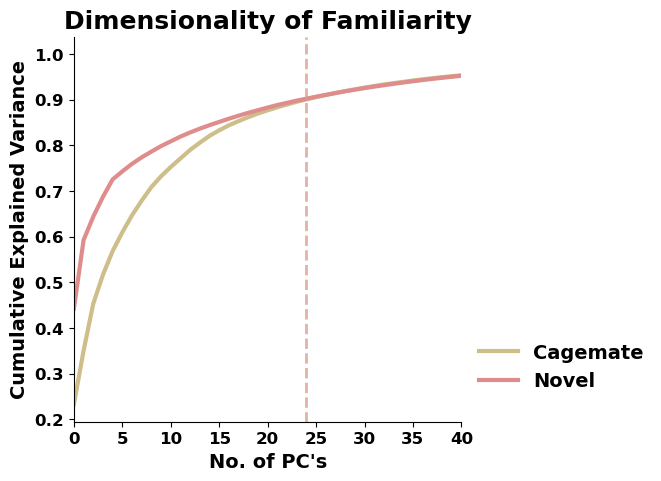

In [26]:
plt.figure(figsize=(5, 5))
plt.plot(cagemate_pca_results.cumulative_variance, label='Cagemate', color = '#CDBE8A', linewidth = 3)
plt.plot(novel_pca_results.cumulative_variance, label='Novel', color = '#DF8C8C', linewidth = 3)
threshold_x1 = None
threshold_x2 = None

for i in range(35):
    if cagemate_pca_results.cumulative_variance[i] > .90 and threshold_x1 is None:
        threshold_x1 = i
    if novel_pca_results.cumulative_variance[i] > .90 and threshold_x2 is None:
        threshold_x2 = i
    if threshold_x1 is not None and threshold_x2 is not None:
        break

# Add vertical dashed lines if thresholds are found
if threshold_x1 is not None:
    plt.axvline(x=threshold_x1, color='#CDBE8A', linestyle='--', alpha=0.5, linewidth = 2)
if threshold_x2 is not None:
    plt.axvline(x=threshold_x2, color='#DF8C8C', linestyle='--', alpha=0.5, linewidth = 2)
plt.xlim(0,40)
plt.legend(frameon=False, fontsize = 14, bbox_to_anchor = (1,0.25))
plt.xlabel("No. of PC's", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Cumulative Explained Variance', fontsize = 14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("Dimensionality of Familiarity", fontsize = 18)
plt.show()

Excluding 33_nov_p1_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


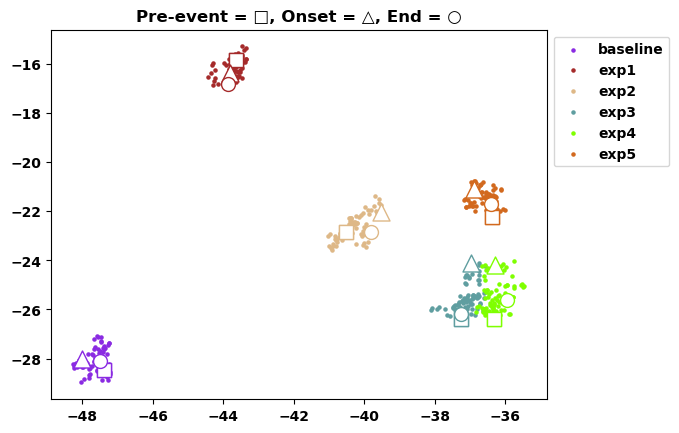

In [11]:
novel_pc_dict = pca_trajectories.avg_trajectories_pca(novel_collection, 5, 3, min_neurons=5, plot = True)


In [47]:
import importlib
importlib.reload(pca_trajectories)
# cagemate_collection.analyze(timebin = 100, ignore_freq = 0.5, smoothing_window=250)
# geo_dist = pca_trajectories.avg_geo_dist(cagemate_collection, 3, 1, percent_var=90, post_window=0, min_neurons = 5)
# geo_dist

<module 'spike.spike_analysis.pca_trajectories' from 'c:\\Users\\megha\\Documents\\GitHub\\diff_fam_social_memory_ephys\\spike\\spike_analysis\\pca_trajectories.py'>

In [48]:
from importlib import reload
reload(pca_trajectories)
novel_collection.analyze(timebin = 100, ignore_freq = 0.5, smoothing_window=250)
geo_dist = pca_trajectories.avg_geo_dist(novel_collection, events = ['exp1 sniff', 'exp2 sniff', 'exp3 sniff', 'exp4 sniff', 'exp5 sniff'], event_length=3, pre_window=1, percent_var=90, post_window=0, min_neurons = 5)
avg_vals_df = geo_dist.mean()
avg_vals = avg_vals_df.values.tolist()
avg_sems = geo_dist.sem()
avg_sems = avg_sems.values.tolist()
geo_dist


All set to analyze
Excluding 33_nov_p1_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\

,exp1 sniff_exp2 sniff,exp1 sniff_exp3 sniff,exp1 sniff_exp4 sniff,exp1 sniff_exp5 sniff,exp2 sniff_exp3 sniff,exp2 sniff_exp4 sniff,exp2 sniff_exp5 sniff,exp3 sniff_exp4 sniff,exp3 sniff_exp5 sniff,exp4 sniff_exp5 sniff
11_nov_p1_merged.rec,292.387337,336.145172,358.337141,307.957234,215.684141,247.091921,216.842889,194.222893,201.303890,203.328743
12_nov_p1_merged.rec,163.483123,190.489957,255.441680,145.644136,207.942041,266.985986,195.567841,249.572714,212.980859,259.266981
13_nov_p1_merged.rec,219.560743,204.833680,236.693035,142.814071,192.025698,168.608171,192.694397,203.192833,178.657296,183.284439
21_nov_p1_merged.rec,109.946979,184.450929,211.433597,199.408201,183.493487,210.489699,189.884770,143.647852,186.256494,218.902250
22_nov_p1_merged.rec,147.825415,181.223231,285.979374,156.853160,160.623403,246.584973,157.257542,222.368462,130.109183,242.704326
24_nov_p1_merged.rec,181.854082,179.310182,178.981184,172.744868,161.056208,152.447244,196.423210,163.161597,206.595296,204.426719
32_nov_p1_merged.rec,191.238077,205.228455,195.250793,195.411836,193.760105,185.874893,233.183504,163.224668,208.144935,223.853688
41_nov_p1_merged.rec,247.870337,304.861281,339.583552,378.882821,248.524334,260.658571,313.695839,217.653315,286.962053,265.066801
44_nov_p1_merged.rec,180.489930,264.538639,280.983671,205.348264,202.037377,224.082902,196.655297,196.800369,211.636036,213.241339


In [49]:
novel_geo_dist = pca_trajectories.avg_geo_dist(novel_collection, events = ['exp1 sniff', 'exp2 sniff', 'exp3 sniff', 'exp4 sniff', 'exp5 sniff'], event_length=3, pre_window=1, percent_var=90, post_window=0, min_neurons = 5)
novel_geo_dist
avg_vals_df = novel_geo_dist.mean()
avg_vals_df

Excluding 33_nov_p1_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\

exp1 sniff_exp2 sniff    192.739558
exp1 sniff_exp3 sniff    227.897947
exp1 sniff_exp4 sniff    260.298225
exp1 sniff_exp5 sniff    211.673843
exp2 sniff_exp3 sniff    196.127421
exp2 sniff_exp4 sniff    218.091596
exp2 sniff_exp5 sniff    210.245032
exp3 sniff_exp4 sniff    194.871634
exp3 sniff_exp5 sniff    202.516227
exp4 sniff_exp5 sniff    223.786143
dtype: float64

In [50]:
from matplotlib.colors import LinearSegmentedColormap
def create_comparison_matrix(df):
    # Get unique experiments
    experiments = sorted(list(set([exp for col in df.columns for exp in col.split('_')])))
    n = len(experiments)
    
    # Create empty matrix
    matrix = np.zeros((n, n))
    
    # Fill matrix
    for i, exp1 in enumerate(experiments):
        for j, exp2 in enumerate(experiments):
            if i == j:
                matrix[i,j] = 1
            else:
                col1 = f"{exp1}_{exp2}"
                col2 = f"{exp2}_{exp1}"
                if col1 in df.columns:
                    matrix[i,j] = df[col1].mean()
                elif col2 in df.columns:
                    matrix[i,j] = df[col2].mean()
    
    return pd.DataFrame(matrix, index=experiments, columns=experiments)

def plot_comparison_heatmap(df, title, color, diagonal_color, vmin):
    # Create comparison matrix
    matrix = create_comparison_matrix(df)
    
    # Create figure
    plt.figure(figsize=(5, 4))
    n_bins = 100  # Number of color gradients
    cmap = LinearSegmentedColormap.from_list('custom', color, N=n_bins)
    # Create heatmap
    sns.heatmap(matrix, 
                annot=True, 
                cmap=cmap,
                fmt='.0f',
                square=True,
                cbar_kws={'label': 'AU Distance'},
                vmin = vmin)
    for i in range(len(matrix)):
        plt.plot(i + 0.5, i + 0.5, 'o', color=diagonal_color, markersize=25, zorder =100)
    
    plt.title(title, fontsize = 16)
    plt.tight_layout()
    return plt



<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\ephys_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

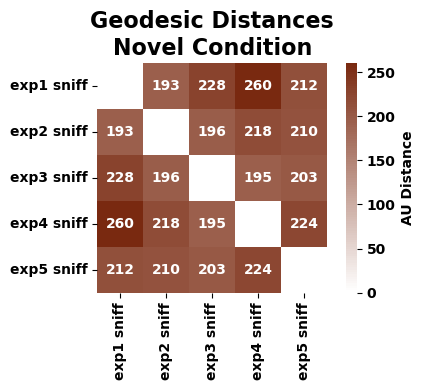

In [51]:
plot_comparison_heatmap(novel_geo_dist, title = "Geodesic Distances\nNovel Condition", color = ['white', '#792910'], diagonal_color='white', vmin = 0)

In [52]:
avg_vals = np.array(avg_vals_df.values.tolist())
avg_vals = avg_vals[[2, 3, 9]]
avg_sems = geo_dist.sem()

avg_sems = np.array(avg_sems.values.tolist())
avg_sems = avg_sems[[2,3,9]]

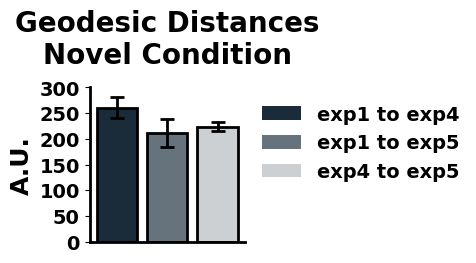

In [53]:

color_id_dict = {'exp1 to exp4': hex_2_rgb('#1a2c3a'),  
                'exp1 to exp5': hex_2_rgb('#66727c'),
                'exp4 to exp5': hex_2_rgb('#ccd0d3')
                }
hatches = ['','','']  
plt.figure(figsize= (2,2))           
plt.bar(color_id_dict.keys(), avg_vals, yerr = avg_sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2, error_kw={'elinewidth': 2, 'capthick': 2})
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(50))
plt.ylim(0,300)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Geodesic Distances\nNovel Condition', fontsize = 20, y =1.1)
plt.show()

In [38]:
geo_dist = pca_trajectories.avg_geo_dist(cagemate_collection, events = ['exp1 sniff', 'exp2 sniff', 'exp3 sniff', 'exp4 sniff', 'exp5 sniff'], event_length=3, pre_window=1, percent_var=90, post_window=0, min_neurons = 5)
geo_dist
avg_vals_df = geo_dist.mean()
avg_vals_df

c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


exp1 sniff_exp2 sniff    185.354892
exp1 sniff_exp3 sniff    202.212853
exp1 sniff_exp4 sniff    205.888822
exp1 sniff_exp5 sniff    216.122672
exp2 sniff_exp3 sniff    200.450727
exp2 sniff_exp4 sniff    206.394413
exp2 sniff_exp5 sniff    229.493241
exp3 sniff_exp4 sniff    205.700439
exp3 sniff_exp5 sniff    232.697252
exp4 sniff_exp5 sniff    217.818613
dtype: float64

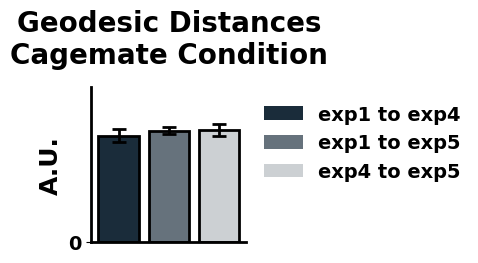

In [44]:
avg_vals = np.array(avg_vals_df.values.tolist())
avg_vals = avg_vals[[2, 3, 9]]
avg_sems = geo_dist.sem()

avg_sems = np.array(avg_sems.values.tolist())
avg_sems = avg_sems[[2,3,9]]
color_id_dict = {'exp1 to exp4': hex_2_rgb('#1a2c3a'),  
                'exp1 to exp5': hex_2_rgb('#66727c'),
                'exp4 to exp5': hex_2_rgb('#ccd0d3')
                }
hatches = ['','','']  
plt.figure(figsize= (2,2))           
plt.bar(color_id_dict.keys(), avg_vals, yerr = avg_sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2, error_kw={'elinewidth': 2, 'capthick': 2})
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(700))
plt.ylim(0,300)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Geodesic Distances\nCagemate Condition', fontsize = 20, y =1.1)
plt.show()

<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\ephys_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

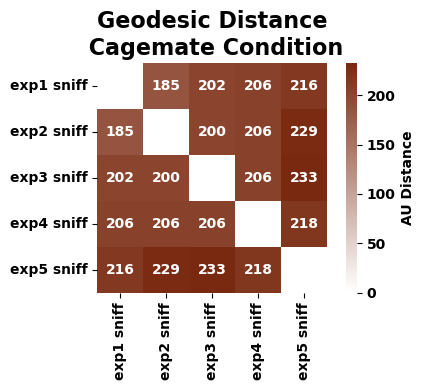

In [40]:
plot_comparison_heatmap(geo_dist, title = "Geodesic Distance\n Cagemate Condition", color = ['white', '#792910'], diagonal_color='white', vmin = 0)


In [54]:

dimensionality = []
for recording in novel_collection.recordings:
    pca_trajectories.avg_trajectories_pca(recording, events = ['exp1 sniff', 'exp5 sniff'], event_length=5, pre_window = 3, min_neurons=5, plot = False)
    total_var = 0
    for i in range(len(novel_pc_dict.explained_variance)):
        total_var = total_var + novel_pc_dict.explained_variance[i]
        if total_var > .9:
            dimensionality.append(i)
            break
            

print(np.mean(np.array(dimensionality)))

c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


NameError: name 'novel_pc_dict' is not defined

In [ ]:
dimensionality = []
for recording in cagemate_collection.recordings:
    cagemate_pc_dict = pca_trajectories.avg_trajectories_pca(recording, events = ['exp1 sniff', 'exp2 sniff', 'exp3 sniff', 'exp4 sniff', 'exp5 sniff'], event_length=3, pre_window = 1, min_neurons=5, plot = False)
    total_var = 0
    if cagemate_pc_dict:
        for i in range(len(cagemate_pc_dict.explained_variance)):
            total_var = total_var + cagemate_pc_dict.explained_variance[i]
            if total_var > .9:
                dimensionality.append(i)
                break
            

print(np.mean(np.array(dimensionality)))

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2654257200.py, line 6)

In [57]:
dimensionality = []
for recording in novel_collection.recordings:
    novel_pc_dict = pca_trajectories.avg_trajectories_pca(recording, events = ['exp1 sniff', 'exp2 sniff', 'exp3 sniff', 'exp4 sniff', 'exp5 sniff'], event_length=3, pre_window = 1, min_neurons=5, plot = False)
    total_var = 0
    if novel_pc_dict:
        for i in range(len(novel_pc_dict.explained_variance)):
            total_var = total_var + novel_pc_dict.explained_variance[i]
            if total_var > .9:
                dimensionality.append(i)
                break
            

print(np.mean(np.array(dimensionality)))

Excluding 33_nov_p1_merged.rec with 1 neurons
4.444444444444445


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\

c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


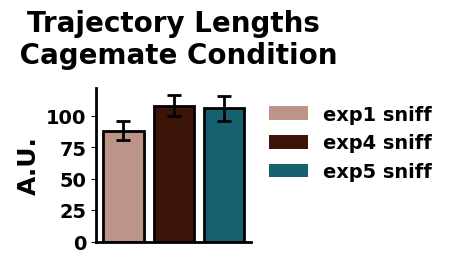

,Comparison,t_statistic,p_value,p_adjusted,significant
0,exp1 sniff_exp4,-3.670051,0.006309,0.018927,True
1,exp1 sniff_exp5,-2.165473,0.062256,0.124512,False
2,exp4 sniff_exp5,0.268492,0.795115,0.795115,False


In [58]:
from scipy.spatial.distance import euclidean
from statsmodels.stats.multitest import multipletests
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in cagemate_collection.recordings:
    pc_result = pca_trajectories.avg_trajectories_pca(recording, event_length = 3, pre_window = 1,
                                                 events = ['exp1 sniff',
                                                           'exp2 sniff',
                                                            'exp3 sniff',
                                                           'exp4 sniff',
                                                           'exp5 sniff'], min_neurons=5, plot = False)
    if pc_result:
        [traj_len, event_order] = trajectory_length(pc_result.transformed_data, pc_result.labels)
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)
means_for_plotting = means[[0,3,4]]
sems_for_plotting = sems[[0,3,4]]

t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,3])
t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,4])
t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,4])
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1 sniff_exp4', 'exp1 sniff_exp5', 'exp4 sniff_exp5'],
   't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

# Adjust p-values using Holm-Bonferroni
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'exp1 sniff': hex_2_rgb('#bc9488'), 
                'exp4 sniff': hex_2_rgb('#3c1508'),
                  'exp5 sniff':  hex_2_rgb('#15616F')}
hatches = ['','','']  
x = [0.5,1,1.5]
plt.figure(figsize= (2,2))           
plt.bar(x, means_for_plotting, yerr = sems_for_plotting,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(300))
# plt.ylim(500,1500)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Cagemate Condition', fontsize = 20, y = 1.1)
plt.show()

stats_df


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\

Excluding 33_nov_p1_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


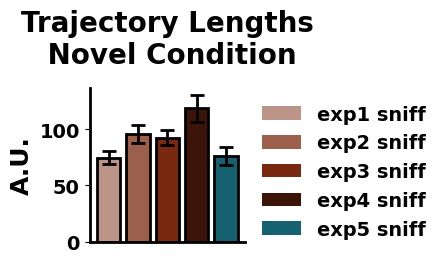

,Comparison,t_statistic,p_value,p_adjusted,significant
0,exp1 sniff_exp4,-3.411426,0.009204,0.027611,True
1,exp1 sniff_exp5,-0.217480,0.833278,0.833278,False
2,exp4 sniff_exp5,3.216389,0.012306,0.027611,True


In [59]:
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in novel_collection.recordings:
    pc_result = pca_trajectories.avg_trajectories_pca(recording, event_length = 3, pre_window = 1,
                                                 events = ['exp1 sniff',
                                                           'exp2 sniff',
                                                            'exp3 sniff',
                                                           'exp4 sniff',
                                                           'exp5 sniff'], min_neurons=5, plot = False)
    if pc_result:
        [traj_len, event_order] = trajectory_length(pc_result.transformed_data, pc_result.labels)
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)

t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,3])
t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,4])
t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,4])
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1 sniff_exp4', 'exp1 sniff_exp5', 'exp4 sniff_exp5'],
   't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

# Adjust p-values using Holm-Bonferroni
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'exp1 sniff': hex_2_rgb('#bc9488'), 
                 'exp2 sniff' :hex_2_rgb('#9b5f4c'),
                 'exp3 sniff': hex_2_rgb('#792910'),
                'exp4 sniff': hex_2_rgb('#3c1508'),
                  'exp5 sniff':  hex_2_rgb('#15616F')}
hatches = ['','','', '', '']  
x = [0, 0.5,1,1.5, 2]
plt.figure(figsize= (2,2))           
plt.bar(x, means, yerr = sems,
            color = color_id_dict.values(),
            edgecolor = ['black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(20))
# plt.ylim(40,100)
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Novel Condition', fontsize = 20, y = 1.1)
plt.show()

stats_df

c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


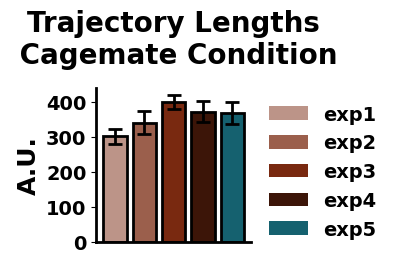

In [ ]:
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in cagemate_collection.recordings:
    pc_result = pca_trajectories.avg_trajectories_pca(recording, event_length = 3, pre_window = 1,
                                                 events = ['exp1',
                                                           'exp2',
                                                            'exp3',
                                                           'exp4',
                                                           'exp5'], min_neurons=5, plot = False)
    if pc_result:
        [traj_len, event_order] = trajectory_length(pc_result.transformed_data, pc_result.labels)
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)

t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,3])
t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,4])
t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,4])
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1_exp4', 'exp1_exp5', 'exp4_exp5'],
   't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

# Adjust p-values using Holm-Bonferroni
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'exp1': hex_2_rgb('#bc9488'), 
                 'exp2' :hex_2_rgb('#9b5f4c'),
                 'exp3': hex_2_rgb('#792910'),
                'exp4': hex_2_rgb('#3c1508'),
                  'exp5':  hex_2_rgb('#15616F')}
hatches = ['','','', '', '']  
x = [0, 0.5,1,1.5, 2]
plt.figure(figsize= (2,2))           
plt.bar(x, means, yerr = sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black', 'black', 'black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(200))
# plt.ylim(600,1600)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Cagemate Condition', fontsize = 20, y = 1.1)
plt.show()

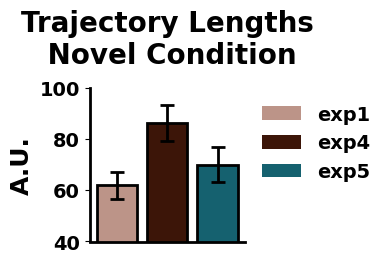

,Comparison,t_statistic,p_value,p_adjusted,significant
0,exp1_exp4,-3.086491,0.014969,0.044907,True
1,exp1_exp5,-1.960923,0.085536,0.085536,False
2,exp4_exp5,2.530445,0.035231,0.070462,False


In [ ]:
from scipy.spatial.distance import euclidean
from statsmodels.stats.multitest import multipletests
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in novel_collection.recordings:
    pc_result = pca_trajectories.avg_trajectories_pca(recording, event_length = 3, pre_window = 1,
                                                 events = ['exp1',
                                                           'exp2',
                                                            'exp3',
                                                           'exp4',
                                                           'exp5'], min_neurons=5, plot = False)
    if pc_result:
        [traj_len, event_order] = trajectory_length(pc_result.transformed_data, pc_result.labels)
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)
means_for_plotting = means[[0,3,4]]
sems_for_plotting = sems[[0,3,4]]

t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,3])
t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,4])
t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,4])
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1_exp4', 'exp1_exp5', 'exp4_exp5'],
   't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

# Adjust p-values using Holm-Bonferroni
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'exp1': hex_2_rgb('#bc9488'), 
                'exp4': hex_2_rgb('#3c1508'),
                  'exp5':  hex_2_rgb('#15616F')}
hatches = ['','','']  
x = [0.5,1,1.5]
plt.figure(figsize= (2,2))           
plt.bar(x, means_for_plotting, yerr = sems_for_plotting,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(20))
plt.ylim(40,100)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Novel Condition', fontsize = 20, y = 1.1)
plt.show()

stats_df

c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


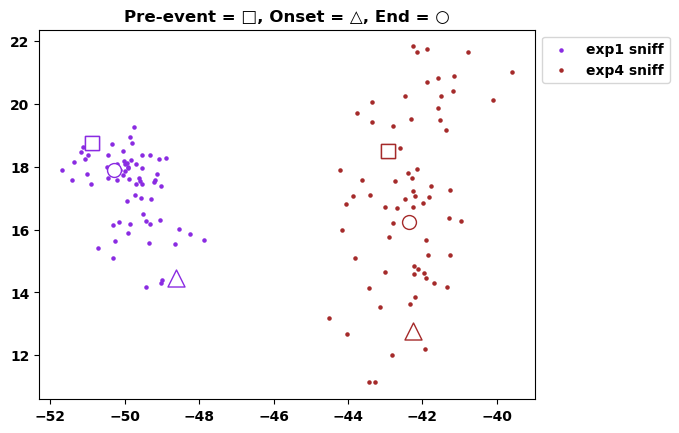

PCA Result with:
Events: exp1 sniff, exp4 sniff
Timebins per event: 70.0
Total neurons: 134
Number of recordings: 11
Number of Pcs needed to explain 90% of variance 22


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


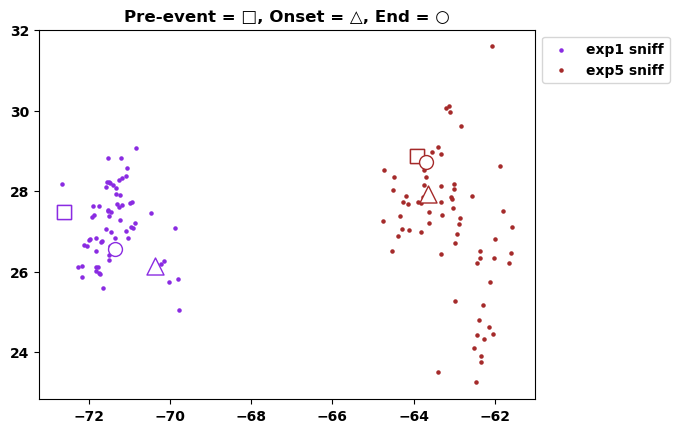

PCA Result with:
Events: exp1 sniff, exp5 sniff
Timebins per event: 70.0
Total neurons: 134
Number of recordings: 11
Number of Pcs needed to explain 90% of variance 18


In [62]:
reload(pca_trajectories)
print(pca_trajectories.avg_trajectories_pca(cagemate_collection, 4,3, 0, events = ['exp1 sniff', 'exp4 sniff']))
print(pca_trajectories.avg_trajectories_pca(cagemate_collection, 4,3, 0, events = ['exp1 sniff', 'exp5 sniff']))

In [63]:
import spike.spike_analysis.decoders as decoders 
num_fold = 5
event_length = 4
pre_window = 3
post_window = 0
min_neurons = 5


cagemate_1v4_results = decoders.trial_decoder(cagemate_collection,
                                              num_fold = num_fold,
                                              no_PCs = 22,
                                              events = ['exp1 sniff', 'exp4 sniff'],
                                              event_length = event_length,
                                              pre_window = pre_window,
                                              post_window = post_window,
                                              min_neurons = min_neurons,
                                              plot = False)

cagemate_1v5_results = decoders.trial_decoder(cagemate_collection,
                                              num_fold = num_fold,
                                              no_PCs = 18,
                                              events = ['exp1 sniff', 'exp5 sniff'],
                                              event_length = event_length,
                                              pre_window = pre_window,
                                              post_window = post_window,
                                              min_neurons = min_neurons,
                                              plot = False)

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


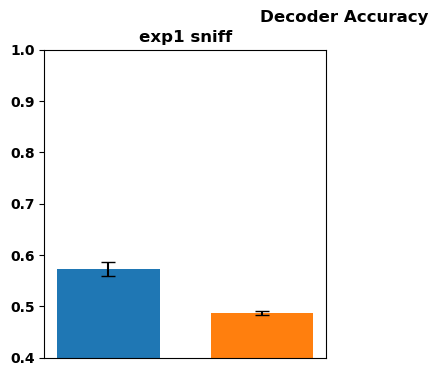

In [64]:
cagemate_1v4_results.plot_average()

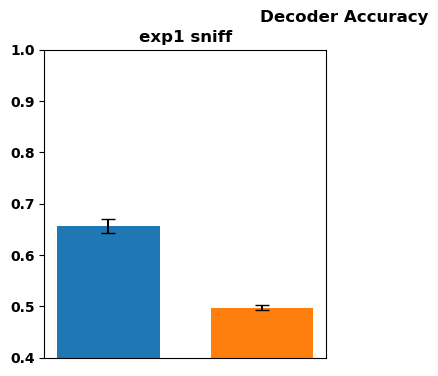

In [65]:
cagemate_1v5_results.plot_average()

c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


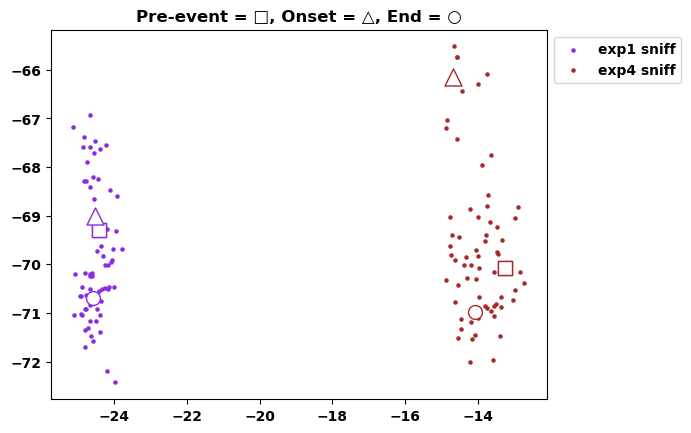

PCA Result with:
Events: exp1 sniff, exp4 sniff
Timebins per event: 70.0
Total neurons: 131
Number of recordings: 10
Number of Pcs needed to explain 90% of variance 15


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


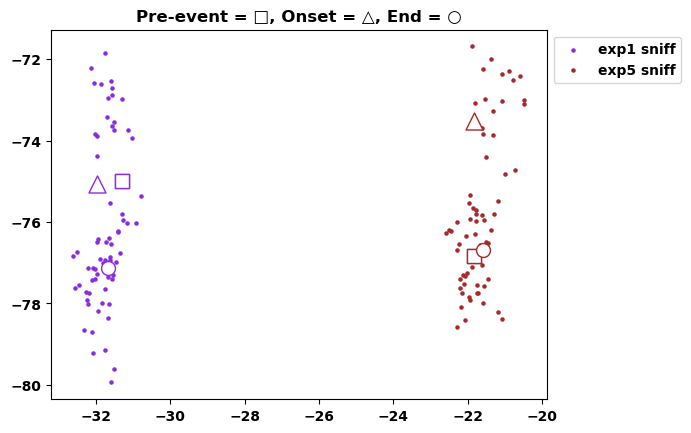

PCA Result with:
Events: exp1 sniff, exp5 sniff
Timebins per event: 70.0
Total neurons: 131
Number of recordings: 10
Number of Pcs needed to explain 90% of variance 14


In [66]:
print(pca_trajectories.avg_trajectories_pca(novel_collection, 4,3, 0, events = ['exp1 sniff', 'exp4 sniff']))
print(pca_trajectories.avg_trajectories_pca(novel_collection, 4,3, 0, events = ['exp1 sniff', 'exp5 sniff']))

In [67]:
novel_1v4_results = decoders.trial_decoder(novel_collection,
                                              num_fold = num_fold,
                                              no_PCs = 15,
                                              events = ['exp1 sniff', 'exp4 sniff'],
                                              event_length = event_length,
                                              pre_window = pre_window,
                                              post_window = post_window,
                                              min_neurons = min_neurons,
                                              plot = False)

novel_1v5_results = decoders.trial_decoder(novel_collection,
                                              num_fold = num_fold,
                                              no_PCs = 14,
                                              events = ['exp1 sniff', 'exp5 sniff'],
                                              event_length = event_length,
                                              pre_window = pre_window,
                                              post_window = post_window,
                                              min_neurons = min_neurons,
                                              plot = False)

Excluding 33_nov_p1_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Excluding 33_nov_p1_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


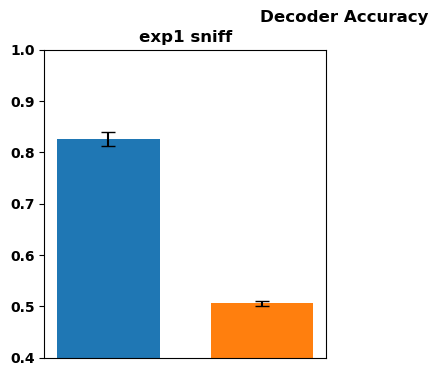

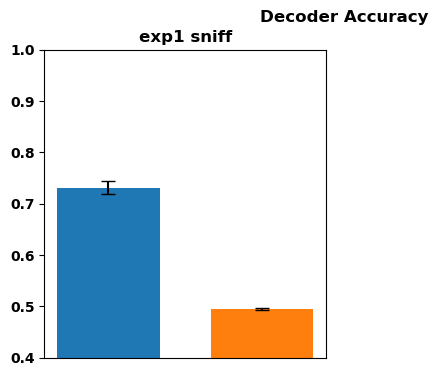

In [68]:
novel_1v4_results.plot_average()
novel_1v5_results.plot_average()

In [69]:
for recording in novel_collection.recordings:
    novel = np.concatenate([recording.event_dict['exp1 sniff'], recording.event_dict['exp5 sniff']], axis = 0)
    recording.event_dict['novel'] = novel
    not_novel = np.concatenate([recording.event_dict['exp3 sniff'], recording.event_dict['exp4 sniff']], axis = 0)
    recording.event_dict['not_novel'] = not_novel
for recording in cagemate_collection.recordings:
    novel = np.concatenate([recording.event_dict['exp1 sniff'], recording.event_dict['exp5 sniff']], axis = 0)
    recording.event_dict['novel'] = novel
    not_novel = np.concatenate([recording.event_dict['exp3 sniff'], recording.event_dict['exp4 sniff']], axis = 0)
    recording.event_dict['not_novel'] = not_novel

In [70]:
print(pca_trajectories.avg_trajectories_pca(novel_collection, 4,3, 0, events = ['novel', 'not_novel'], plot = False))
print(pca_trajectories.avg_trajectories_pca(cagemate_collection, 4,3, 0, events = ['novel', 'not_novel'], plot = False))

PCA Result with:
Events: novel, not_novel
Timebins per event: 70.0
Total neurons: 131
Number of recordings: 10
Number of Pcs needed to explain 90% of variance 14
PCA Result with:
Events: novel, not_novel
Timebins per event: 70.0
Total neurons: 134
Number of recordings: 11
Number of Pcs needed to explain 90% of variance 21


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [72]:
novel_novel_results = decoders.trial_decoder(novel_collection,
                                              num_fold = num_fold,
                                              no_PCs = 14,
                                              events = ['novel', 'not_novel'],
                                              event_length = event_length,
                                              pre_window = pre_window,
                                              post_window = post_window,
                                              min_neurons = min_neurons,
                                              plot = False)

cagemate_novel_results = decoders.trial_decoder(cagemate_collection,
                                              num_fold = num_fold,
                                              no_PCs = 21,
                                              events = ['novel', 'not_novel'],
                                              event_length = event_length,
                                              pre_window = pre_window,
                                              post_window = post_window,
                                              min_neurons = min_neurons,
                                              plot = False)

Excluding 33_nov_p1_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


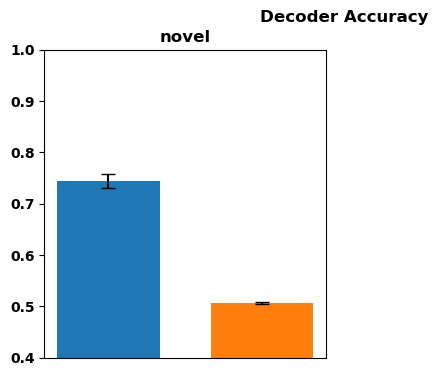

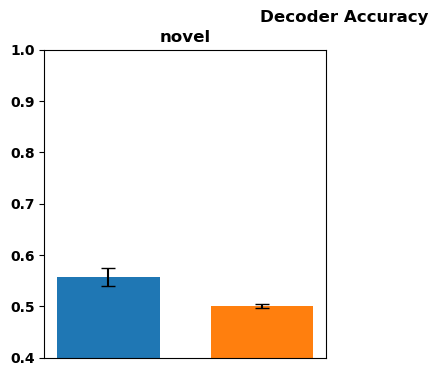

In [73]:
novel_novel_results.plot_average()
cagemate_novel_results.plot_average()

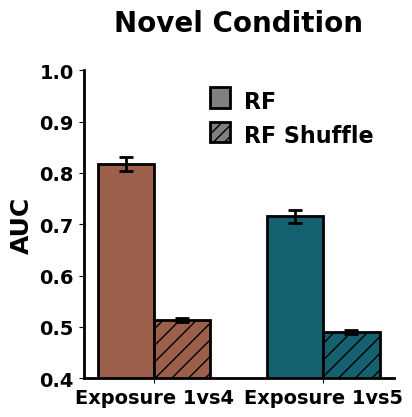

In [74]:
from matplotlib.patches import Patch
def plot_multiple_decoders(decoder_results, title, color_list, legend_titles, figsize, start=0, stop=None, ):
    bar_width = 0.2
    plt.figure(figsize=figsize)
    
    bar_position = 0  # Starting position for bars
    bar_centers = []  # Store center positions for labels
    j = 0
    
    # First, create bars without labels
    for decoder in decoder_results:
        key = list(decoder.results.keys())[0]
        results = list(decoder.results.values())[0]
        
        total_event = decoder.event_length + decoder.post_window
        x = np.linspace(-decoder.pre_window, total_event, np.array(results.roc_auc).shape[0])
        
        if start is not None:
            plot_start = np.where(x >= start)[0][0]
        if stop is None:
            plot_stop = results.roc_auc.shape[0]
        if stop is not None:
            plot_stop = np.where(x <= stop)[0][-1] + 1
            
        rf_avg = np.mean(np.mean(results.roc_auc[start:stop], axis=0), axis=0)
        rf_sem = sem(np.mean(results.roc_auc[plot_start:plot_stop], axis=0))
        rf_shuffle_avg = np.mean(np.mean(results.roc_auc_shuffle[plot_start:plot_stop], axis=0), axis=0)
        rf_shuffle_sem = sem(np.mean(results.roc_auc_shuffle[plot_start:plot_stop], axis=0))
        
        # Plot bars without labels
        plt.bar(bar_position, rf_avg, bar_width, 
               yerr=rf_sem, capsize=5, color=color_list[j], 
               edgecolor='black', linewidth=2,
               error_kw={'elinewidth': 2, 'capthick': 2})
        plt.bar(bar_position + bar_width, rf_shuffle_avg, bar_width, 
               yerr=rf_shuffle_sem, capsize=5, color=color_list[j], 
               hatch='//', edgecolor='black', linewidth=2,
               error_kw={'elinewidth': 2, 'capthick': 2})
        
        # Store center position for this pair of bars
        bar_centers.append(bar_position + bar_width/2)
        
        bar_position += 0.6
        j += 1
    
    # Add centered labels under each pair of bars
    plt.xticks(bar_centers, legend_titles, fontsize=12)
    
    # Create custom legend for RF and RF Shuffle
    legend_elements = [
    Patch(facecolor='grey', edgecolor='black', linewidth=2, label='RF'),
    Patch(facecolor='grey', edgecolor='black', linewidth=2, hatch='///', label='RF Shuffle')
    ]

    # Create the legend with modified properties
    leg = plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1), 
                    frameon=False, fontsize=16)

# Adjust the size of the patches in the legend
    for patch in leg.get_patches():
        patch.set_height(15)  # Adjust this value to change height
        patch.set_y(0)
        patch.set_width(15) 
        patch.set_x(20)
    
    plt.ylim(0.4, 1)
    plt.ylabel('AUC', fontsize=18)
    plt.xticks(fontsize = 14)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    plt.title(title, fontsize=20, y = 1.1)
    plt.yticks(fontsize=14)
    plt.show()

plot_multiple_decoders([novel_1v4_results, novel_1v5_results], title = "Novel Condition", color_list = ['#9b5f4c','#15616F'], start = 0 , stop = 3, legend_titles = ['Exposure 1vs4', 'Exposure 1vs5'], figsize = (4,4))

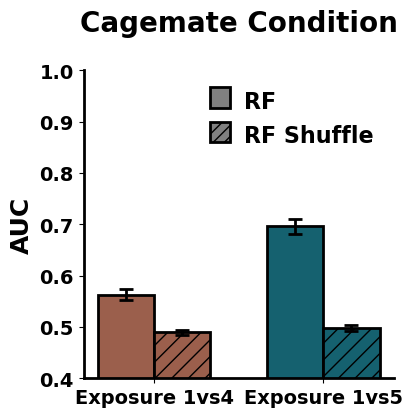

In [75]:
plot_multiple_decoders([cagemate_1v4_results, cagemate_1v5_results], title = "Cagemate Condition", color_list = ['#9b5f4c','#15616F'], start = 0 , stop = 3, legend_titles = ['Exposure 1vs4', 'Exposure 1vs5'], figsize = (4,4))

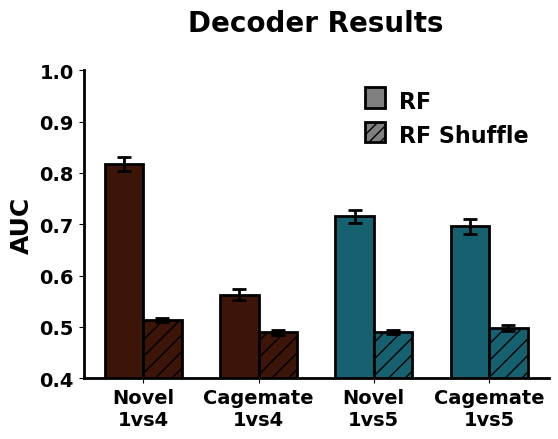

In [76]:
plot_multiple_decoders([novel_1v4_results, cagemate_1v4_results, novel_1v5_results, cagemate_1v5_results], title = "Decoder Results", color_list = ['#3c1508','#3c1508','#15616F','#15616F'], start = 0 , stop = 3, legend_titles = ['Novel\n1vs4', 'Cagemate\n1vs4', 'Novel\n1vs5', 'Cagemate\n1vs5'], figsize = (6,4))

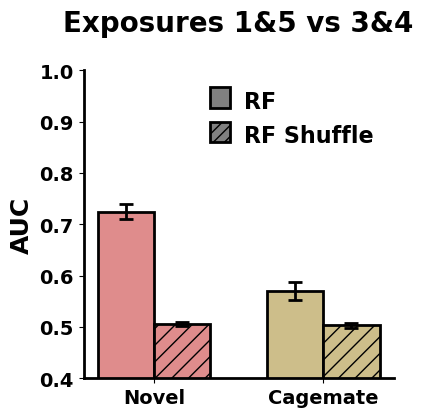

In [77]:
plot_multiple_decoders([novel_novel_results, cagemate_novel_results], title = "Exposures 1&5 vs 3&4", color_list = ['#DF8C8C','#CDBE8A'], start = 0 , stop = 3, legend_titles = ['Novel', 'Cagemate'], figsize = (4,4))

In [78]:

dimensionality = []
for recording in cagemate_collection.recordings:
    cagemate_pc_dict = pca_trajectories.avg_trajectories_pca(recording, events = ['exp1 sniff', 'exp2 sniff', 'exp3 sniff', 'exp4 sniff', 'exp5 sniff'], event_length=3, pre_window = 1, min_neurons=5, plot = False)
    total_var = 0
    if cagemate_pc_dict:
        for i in range(len(cagemate_pc_dict.explained_variance)):
            total_var = total_var + cagemate_pc_dict.explained_variance[i]
            if total_var > .9:
                dimensionality.append(i)
                break
            

print(np.mean(np.array(dimensionality)))

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
5.333333333333333


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\

In [79]:

whole_collection = 0
whole_collection = cagemate_collection

In [80]:

for recording in novel_collection.recordings:
    whole_collection.recordings.append(recording)


In [81]:
print(len(whole_collection.recordings))

21


In [82]:
for recording in whole_collection.recordings:
    print(recording.name)

11_cage_p1_merged.rec
12_cage_p1_merged.rec
13_cage_p1_merged.rec
21_cage_p1_merged.rec
22_cage_p1_merged.rec
24_cage_p1_merged.rec
31_cage_p1_merged.rec
32_cage_p1_merged.rec
33_cage_p1_merged.rec
41_cage_p1_merged.rec
44_cage_p1_merged.rec
11_nov_p1_merged.rec
12_nov_p1_merged.rec
13_nov_p1_merged.rec
21_nov_p1_merged.rec
22_nov_p1_merged.rec
24_nov_p1_merged.rec
32_nov_p1_merged.rec
33_nov_p1_merged.rec
41_nov_p1_merged.rec
44_nov_p1_merged.rec


In [83]:
for recording in whole_collection.recordings:
    novel = np.concatenate([recording.event_dict['exp1 sniff'], recording.event_dict['exp5 sniff']], axis = 0)
    recording.event_dict['novel'] = novel
    not_novel = np.concatenate([recording.event_dict['exp3 sniff'], recording.event_dict['exp4 sniff']], axis = 0)
    recording.event_dict['not_novel'] = not_novel

In [84]:
condition_dict = {"cagemate": [], "novel": []}
for recording in whole_collection.recordings:
    if "cage" in recording.name:
        condition_dict["cagemate"].append(recording.name)
    if "nov" in recording.name:
        condition_dict["novel"].append(recording.name)
print(condition_dict)

{'cagemate': ['11_cage_p1_merged.rec', '12_cage_p1_merged.rec', '13_cage_p1_merged.rec', '21_cage_p1_merged.rec', '22_cage_p1_merged.rec', '24_cage_p1_merged.rec', '31_cage_p1_merged.rec', '32_cage_p1_merged.rec', '33_cage_p1_merged.rec', '41_cage_p1_merged.rec', '44_cage_p1_merged.rec'], 'novel': ['11_nov_p1_merged.rec', '12_nov_p1_merged.rec', '13_nov_p1_merged.rec', '21_nov_p1_merged.rec', '22_nov_p1_merged.rec', '24_nov_p1_merged.rec', '32_nov_p1_merged.rec', '33_nov_p1_merged.rec', '41_nov_p1_merged.rec', '44_nov_p1_merged.rec']}


In [85]:
reload(pca_trajectories)

<module 'spike.spike_analysis.pca_trajectories' from 'c:\\Users\\megha\\Documents\\GitHub\\diff_fam_social_memory_ephys\\spike\\spike_analysis\\pca_trajectories.py'>

In [90]:
events = ['exp1 sniff', 'exp2 sniff', 'exp3 sniff', 'exp4 sniff', 'exp5 sniff']

In [93]:
pca_result = pca_trajectories.avg_trajectories_pca(whole_collection, event_length=4, pre_window = 3, events = events, post_window=0, min_neurons=5, plot= False)

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [94]:
pca_result.matrix_df[condition_dict['cagemate']]

KeyError: "['31_cage_p1_merged.rec', '33_cage_p1_merged.rec'] not in index"

All set to analyze
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


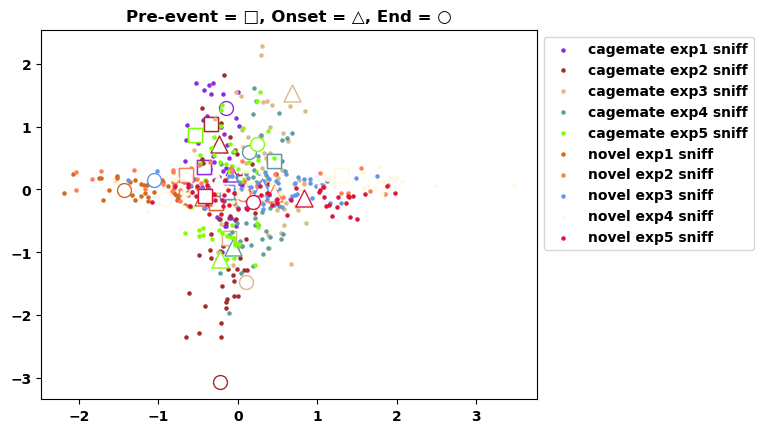

In [102]:
from importlib import reload
reload(pca_trajectories)
events = ['exp1 sniff', 'exp2 sniff', 'exp3 sniff', 'exp4 sniff', 'exp5 sniff']
#events = ['novel', 'not_novel']
event_length=3
pre_window = 3
post_window=0
min_neurons=5
plot= False
whole_collection.analyze(timebin = 100, smoothing_window=250, ignore_freq=0.5)
pca_result = pca_trajectories.condition_pca(whole_collection, condition_dict,events = events, event_length=event_length, pre_window=pre_window, min_neurons=min_neurons, plot=True)

In [98]:
print(pca_result)

PCA Result with:
Events: exp1 sniff, exp2 sniff, exp3 sniff, exp4 sniff, exp5 sniff
Timebins per event: 60.0
Total neurons: 261
Number of recordings: 18
Number of Pcs needed to explain 90% of variance 39


In [99]:
def plot_condition_results_3d(pca_result, title, colors, azim, elev, save = False):
    event_lengths = int(
            (pca_result.event_length + pca_result.pre_window + pca_result.post_window) * 1000 / pca_result.timebin
        )
    
    event_end = int((pca_result.event_length + pca_result.pre_window) * 1000 / pca_result.timebin)
    pre_window = pca_result.pre_window * 1000 / pca_result.timebin
    post_window = pca_result.post_window * 1000 / pca_result.timebin
    pc_var = pca_result.explained_variance
    PCA_key = pca_result.labels
    PCA_matrix = pca_result.transformed_data
    col_counter = 0
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection="3d")
    #plt.subplots_adjust(left=0.3, right=0.99, bottom=0.1, top=0.9)
    for condition in condition_dict.keys():
        for i in range(0, len(PCA_key), event_lengths):
            event_label = PCA_key[i]
            onset = int(i + pca_result.pre_window - 1)
            end = int(i + event_end - 1)
            post = int(i + event_lengths - 1)
            ax.plot3D(
                PCA_matrix[condition][i : i + event_lengths, 0],
                PCA_matrix[condition][i : i + event_lengths, 1],
                PCA_matrix[condition][i : i + event_lengths, 2],
                label=f"{condition} {event_label}",
                color=colors[col_counter],
                linewidth = 5,
                alpha = 0.8
            )
            ax.scatter(
                PCA_matrix[condition][i, 0],
                PCA_matrix[condition][i, 1],
                PCA_matrix[condition][i, 2],
                marker="s",
                s=100,
                c="w",
                edgecolors=colors[col_counter],
            )
            ax.scatter(
                PCA_matrix[condition][onset, 0],
                PCA_matrix[condition][onset, 1],
                PCA_matrix[condition][onset, 2],
                marker="^",
                s=300,
                c="w",
                edgecolors=colors[col_counter],
            )
            ax.scatter(
                PCA_matrix[condition][end, 0],
                PCA_matrix[condition][end, 1],
                PCA_matrix[condition][end, 2],
                marker="o",
                s=200,
                c="w",
                edgecolors=colors[col_counter],
            )
            if post_window != 0:
                ax.scatter(
                    PCA_matrix[condition][post, 0],
                    PCA_matrix[condition][post, 1],
                    PCA_matrix[condition][post, 2],
                    marker="D",
                    s=200,
                    c="w",
                    edgecolors=colors[col_counter],
                )
            col_counter += 1
    ax.legend(loc="upper left", bbox_to_anchor=(.9,1), frameon = False, fontsize = 14)
    # ax.set_xlim(-20, 45)
    # ax.set_ylim(-5, 25)
    # ax.set_zlim(-20, 30)
    ax.view_init(azim = azim, elev =elev)
    ax.set_title(f"{title}", fontsize = 24, y = 1)
    ax.set_xlabel(f"PC1 ({pc_var[0]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_ylabel(f"PC2 ({pc_var[1]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_zlabel(f"PC3 ({pc_var[2]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.yaxis.pane.set_alpha(0.9)
    ax.xaxis.pane.set_alpha(0.9)
    ax.zaxis.pane.set_alpha(0.9)
    plt.tight_layout()
    if save:
        plt.savefig(f'{title}.png', dpi = 600, transparent = True,bbox_inches='tight' )
    plt.show()


def plot_condition_results_2d(pca_result, title, colors, legend_spot, include_cagemate = True, xlim = None, ylim = None,save=False):
    event_lengths = int(
        (pca_result.event_length + pca_result.pre_window + pca_result.post_window) * 1000 / pca_result.timebin
    )
    
    event_end = int((pca_result.event_length + pca_result.pre_window) * 1000 / pca_result.timebin)
    pre_window = pca_result.pre_window * 1000 / pca_result.timebin
    post_window = pca_result.post_window * 1000 / pca_result.timebin
    pc_var = pca_result.explained_variance
    PCA_key = pca_result.labels
    PCA_matrix = pca_result.transformed_data
    col_counter = 0
    
    # Create figure with updated size
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    for condition in condition_dict.keys():
        if not include_cagemate and condition == 'cagemate':
            pass
        else:
            for i in range(0, len(PCA_key), event_lengths):
                event_label = PCA_key[i]
                onset = int(i + pca_result.pre_window - 1)
                end = int(i + event_end - 1)
                post = int(i + event_lengths - 1)
                
                # Plot the continuous line with updated styling
                ax.plot(
                    PCA_matrix[condition][i:i + event_lengths, 0],
                    PCA_matrix[condition][i:i + event_lengths, 1],
                    label=event_label if condition == 'cagemate' else None,
                    color=colors[col_counter],
                    linewidth=5,
                    alpha=0.8,
                    zorder = 1
                )
                
                # Add markers with updated sizes
                ax.scatter(
                    PCA_matrix[condition][i, 0],
                    PCA_matrix[condition][i, 1],
                    marker="s",
                    s=200,
                    c="w",
                    edgecolors=colors[col_counter],
                    zorder = 2
                )
                ax.scatter(
                    PCA_matrix[condition][onset, 0],
                    PCA_matrix[condition][onset, 1],
                    marker="^",
                    s=300,
                    c="w",
                    edgecolors=colors[col_counter],
                    zorder = 3
                )
                ax.scatter(
                    PCA_matrix[condition][end, 0],
                    PCA_matrix[condition][end, 1],
                    marker="o",
                    s=200,
                    c="w",
                    edgecolors=colors[col_counter],
                    zorder = 4
                )
                if post_window != 0:
                    ax.scatter(
                        PCA_matrix[condition][post, 0],
                        PCA_matrix[condition][post, 1],
                        marker="D",
                        s=200,
                        c="w",
                        edgecolors=colors[col_counter],
                        zorder =5
                    )
                col_counter += 1
        
    # Updated legend formatting
    ax.legend(loc="upper left", bbox_to_anchor=legend_spot, frameon=False, fontsize=14)
    
    # ax.set_xlim(-20, 45)
    # ax.set_ylim(-5, 25)
    
    # Updated title and label formatting
    ax.set_title(f"{title}", fontsize=24, y=1.01)
    ax.set_xlabel(f"PC1 ({pc_var[0]*100:.1f}% variance)", fontsize=16)
    ax.set_ylabel(f"PC2 ({pc_var[1]*100:.1f}% variance)", fontsize=16)
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None: 
        ax.set_xlim(xlim)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    
    # Add tight layout
    plt.tight_layout()
    
    if save:
        plt.savefig(f'{title}.png', dpi=600, transparent=True, bbox_inches='tight')
    plt.show()

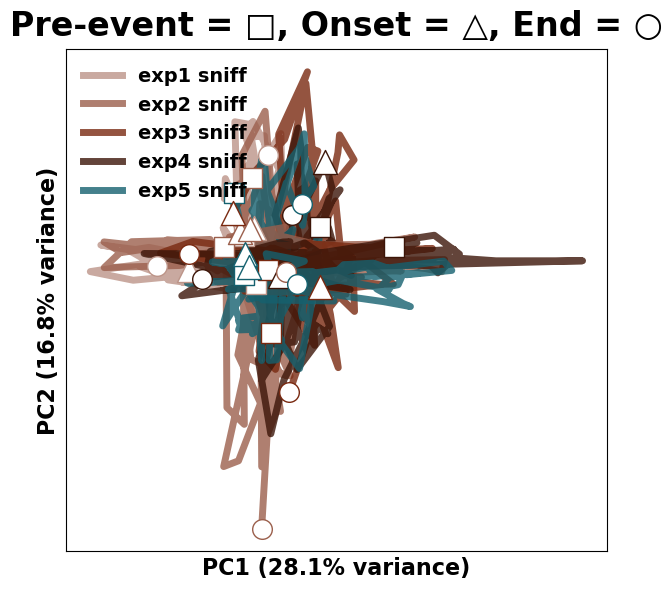

C:\Users\megha\AppData\Local\Temp\ipykernel_28176\3380868870.py:168: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left", bbox_to_anchor=legend_spot, frameon=False, fontsize=14)


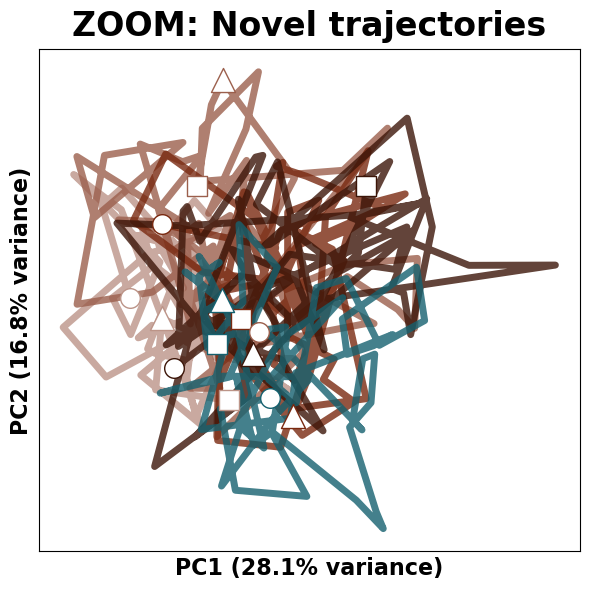

In [104]:



exp_colors = [hex_2_rgb('#bc9488'),
              hex_2_rgb('#9b5f4c'),
              hex_2_rgb('#792910'),
              hex_2_rgb('#3c1508'),
              hex_2_rgb('#15616F'),
              hex_2_rgb('#bc9488'),
              hex_2_rgb('#9b5f4c'),
              hex_2_rgb('#792910'),
              hex_2_rgb('#3c1508'),
              hex_2_rgb('#15616F')]

title = "Pre-event = □, Onset = △, End = ○" 
plot_condition_results_2d(pca_result=pca_result, title = title, colors = exp_colors, legend_spot = (0, 1))
plot_condition_results_2d(pca_result=pca_result, title = 'ZOOM: Novel trajectories', colors = exp_colors, legend_spot = (0, 1),  include_cagemate = False)

In [107]:
from importlib import reload
reload(pca_trajectories)
events = ['exp1 sniff', 'exp2 sniff', 'exp3 sniff', 'exp4 sniff', 'exp5 sniff']
#events = ['novel', 'not_novel']
event_length=3
pre_window = 3
post_window=0
min_neurons=5
plot= False

result_list = pca_trajectories.LOO_PCA(whole_collection, event_length=event_length, pre_window=pre_window, post_window=post_window, events=events, min_neurons= min_neurons, condition_dict=condition_dict, plot = False)

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1

[200.42741262 252.21060837 248.66674714 190.34153869 282.99601917
 210.78401581]
['exp1_cagemate' 'exp4_cagemate' 'exp5_cagemate' 'exp1_novel' 'exp4_novel'
 'exp5_novel']


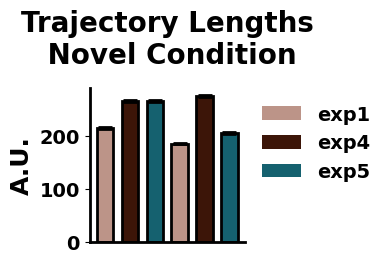

In [81]:
from scipy.spatial.distance import euclidean
from statsmodels.stats.multitest import multipletests
def condition_trajectory_length(pca_dict, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
   
    for condition in pca_dict.keys():
        for j in range(0, len(key), event_len):
            trajectory_length = 0
            for i in range(event_len-1):
                trajectory_length = trajectory_length + euclidean(
                    pca_dict[condition][j+i, :],
                    pca_dict[condition][j+i+1, :])
            trajectory_lengths.append(trajectory_length)
            event_order.append(f"{key[j]}_{condition}")
    return [trajectory_lengths, event_order]


trajectory_lengths = []
orders= []
for loo_result in result_list:
    [traj_len, event_order] = condition_trajectory_length(loo_result.transformed_data, loo_result.labels)
    trajectory_lengths.append(traj_len)
    orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)
print(np.array(trajectory_lengths[1])[[0,3,4,5,8,9]])
print(np.array(orders[1])[[0,3,4,5,8,9]])

means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)
means_for_plotting = means[[0,3,4,5,8,9]]
sems_for_plotting = sems[[0,3,4,5,8,9]]

# t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,3])
# t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,4])
# t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,4])
# p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
# reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
# stats_df = pd.DataFrame({
#    'Comparison': ['exp1_exp4', 'exp1_exp5', 'exp4_exp5'],
#    't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
#    'p_value': p_values,
#    'p_adjusted': p_adjusted,
#    'significant': reject
# })

# Adjust p-values using Holm-Bonferroni
# p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
# reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'exp1': hex_2_rgb('#bc9488'), 
                'exp4': hex_2_rgb('#3c1508'),
                  'exp5':  hex_2_rgb('#15616F'),
                  'exp1': hex_2_rgb('#bc9488'), 
                'exp4': hex_2_rgb('#3c1508'),
                  'exp5':  hex_2_rgb('#15616F')} 
  # Ensures bars don't overlap but aren't too thin
                                # Max width of 0.4 (your original), gets smaller with more bars

# Create evenly spaced x positions based on the number of data points
x = np.arange(len(means_for_plotting))
width = 4 / len(x)
plt.figure(figsize= (2,2))           
plt.bar(x, means_for_plotting, yerr = sems_for_plotting,
            color = color_id_dict.values(),
            edgecolor = 'black',
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = width)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(20))
#plt.ylim(40,100)
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Novel Condition', fontsize = 20, y = 1.1)
plt.show()

#stats_df

In [82]:

def get_indices(repeated_items_list):
    """
    Takes in an indexed key or a list of repeated items,
    creates a list of indices that correspond to each unique item.

    Args (1):
        repeated_items_list: list, list of repeated items

    Returns:
        item_indices: list of tuples, where the first element
            is the first index of an item, and the second
            element is the last index of that item
    """
    is_first = True
    item_indices = []
    for i in range(len(repeated_items_list)):
        if is_first:
            current_item = repeated_items_list[i]
            start_index = 0
            is_first = False
        else:
            if repeated_items_list[i] == current_item:
                end_index = i
                if i == (len(repeated_items_list) - 1):
                    item_indices.append([start_index, end_index])
            else:
                item_indices.append([start_index, end_index])
                start_index = i
                current_item = repeated_items_list[i]
    return item_indices
    
def event_slice(transformed_subsets, key, no_PCs, mode):
    """
    Takes in a matrix T (session x timebins x pcs) (mode = 'multisession')
    or (timebins x pcs) (mode = 'single')
    and an event key to split the matrix by event and trim it to no_PCs.

    Args (3):
        transformed_subsets: np.array, d(session X timebin X PCS)
        key: list of str, each element is an event type and
            corresponds to the timebin dimension indices of
            the transformed_subsets matrix
        no_PCs: int, number of PCs required to explain a variance threshold
        mode: {'multisession', 'single'}; multisession calculates event slices
            for many transformed subsets, single calculates event slices for a
            single session
    Returns:
        trajectories: dict, events to trajectories across
            each LOO PCA embedding
            keys: str, event types
            values: np.array, d=(session x timebins x no_PCs)
    """
    event_indices = get_indices(key)
    events = np.unique(key)
    trajectories = {}
    for i in range(len(event_indices)):
        event = events[i]
        start = event_indices[i][0]
        stop = event_indices[i][1]
        if mode == "multisession":
            event_trajectory = transformed_subsets[:, start : stop + 1, :no_PCs]
        if mode == "single":
            event_trajectory = transformed_subsets[start : stop + 1, :no_PCs]
        trajectories[event] = event_trajectory
    return trajectories


def geodesic_distances(event_trajectories, mode):
    # Get all events
    events = list(event_trajectories.keys())
    
    # Initialize empty DataFrame with events as both rows and columns
    df = pd.DataFrame(index=events, columns=events)
    
    # Fill diagonal with zeros (distance to self is 0)
    for event in events:
        df.loc[event, event] = 0
    
    # Calculate distances for each pair
    pairs = list(combinations(events, 2))
    for pair in pairs:
        event1 = pair[0]
        event2 = pair[1]  # Only calculate each pair once
        dist = distance_bw_trajectories(
            event_trajectories[event1], 
            event_trajectories[event2], 
            mode
        )
        # Fill both symmetric positions in the DataFram
        converted_dist = float(np.mean(np.array(dist)))
        converted_sem = float(sem(np.array(dist)))
        # Fill both symmetric positions in the DataFrame
        df.loc[event1, event2] = converted_dist #converted_sem
        df.loc[event2, event1] = converted_dist #converted_sem

    return df

def distance_bw_trajectories(trajectory1, trajectory2, mode):
    if mode == "multisession":
        geodesic_distances = []
        for session in range(trajectory1.shape[0]):
            dist_bw_tb = 0
            for i in range(trajectory1.shape[1]):
                dist_bw_tb = dist_bw_tb + euclidean(trajectory1[session, i, :], trajectory2[session, i, :])
            geodesic_distances.append(dist_bw_tb)
    if mode == "single":
        dist_bw_tb = 0
        for i in range(trajectory1.shape[0]):
            dist_bw_tb = dist_bw_tb + euclidean(trajectory1[i, :], trajectory2[i, :])
        geodesic_distances = dist_bw_tb
    return geodesic_distances


def get_indices_claude(repeated_items_list):
    """
    Takes in a list of repeated items and returns start/end indices for each unique sequence.
    
    Args:
        repeated_items_list: list of repeated items
    
    Returns:
        list of [start_index, end_index] for each unique sequence
    """  
    result = []
    start = 0
    current = repeated_items_list[0]
    for i, item in enumerate(repeated_items_list[1:], 1):
        if item != current:
            result.append([start, i-1])
            start = i
            current = item    
    # Don't forget the last group
    result.append([start, len(repeated_items_list)-1])
    
    return result

In [ ]:
print(get_indices(master_key))
get_indices_claude(master_key)

[[0, 59], [60, 119], [120, 179], [180, 239], [240, 299], [300, 359], [360, 419], [420, 479], [480, 539], [540, 599]]


[[0, 59],
 [60, 119],
 [120, 179],
 [180, 239],
 [240, 299],
 [300, 359],
 [360, 419],
 [420, 479],
 [480, 539],
 [540, 599]]

In [ ]:
trajectory1 = np.array([
    # Session 1
    [[0],  # timepoint 1
     [1],  # timepoint 2
     [2]], # timepoint 3
    
    # Session 2
    [[0],
     [1],
     [2]]
])

trajectory2 = np.array([
    # Session 1
    [[1],  # timepoint 1
     [2],  # timepoint 2
     [3]], # timepoint 3
    
    # Session 2
    [[2],
     [4],
     [5]]
])

distance_bw_trajectories(trajectory1=trajectory1, trajectory2=trajectory2, mode = 'multisession')

[np.float64(3.0), np.float64(8.0)]

In [83]:
# no_PCs = PCs_needed(explained_variance_ratios, percent_var)
    # event_trajectories = event_slice(transformed_subsets, key, no_PCs, mode="multisession")
    # pairwise_distances = geodesic_distances(event_trajectories, mode="multisession")
#transformed_subsets = [sessions x 300 x 19]
cagemates = []
novels = []
for loo_result in result_list:
    cagemates.append(loo_result.transformed_data['cagemate'][:,:19])
    novels.append(loo_result.transformed_data['novel'][:,:19])
cagemates = np.stack(cagemates)
novels = np.stack(novels)

 
key = result_list[0].labels

prefix1 = "cagemate\n"
prefix2 = "novel\n"

list1 = [prefix1 + item for item in key]
list2 = [prefix2 + item for item in key]
master_key = list1 + list2


transformed_subsets = np.concatenate([cagemates, novels], axis = 1)

print(len(transformed_subsets.shape))
event_trajectories = event_slice(transformed_subsets, master_key, 3, 'multisession')


pairwise_distances = geodesic_distances(event_trajectories, mode="multisession")
pairwise_distances

3


,cagemate\nexp1,cagemate\nexp2,cagemate\nexp3,cagemate\nexp4,cagemate\nexp5,novel\nexp1,novel\nexp2,novel\nexp3,novel\nexp4,novel\nexp5
cagemate\nexp1,0,114.847196,107.959602,125.154375,142.786418,95.782579,84.501876,85.285551,84.830686,88.933045
cagemate\nexp2,114.847196,0,113.701634,118.183251,154.567399,99.721176,94.443543,93.621715,96.589299,96.786212
cagemate\nexp3,107.959602,113.701634,0,106.645828,153.339115,86.503684,87.046665,84.418714,85.445033,85.382349
cagemate\nexp4,125.154375,118.183251,106.645828,0,145.160331,93.412182,96.52405,96.913381,97.176131,91.228082
cagemate\nexp5,142.786418,154.567399,153.339115,145.160331,0,114.69742,117.686006,115.795469,120.351249,109.904859
novel\nexp1,95.782579,99.721176,86.503684,93.412182,114.69742,0,50.755281,59.786363,60.717576,47.631068
novel\nexp2,84.501876,94.443543,87.046665,96.52405,117.686006,50.755281,0,44.73162,47.783769,45.41336
novel\nexp3,85.285551,93.621715,84.418714,96.913381,115.795469,59.786363,44.73162,0,42.958156,42.557883
novel\nexp4,84.830686,96.589299,85.445033,97.176131,120.351249,60.717576,47.783769,42.958156,0,45.519674
novel\nexp5,88.933045,96.786212,85.382349,91.228082,109.904859,47.631068,45.41336,42.557883,45.519674,0


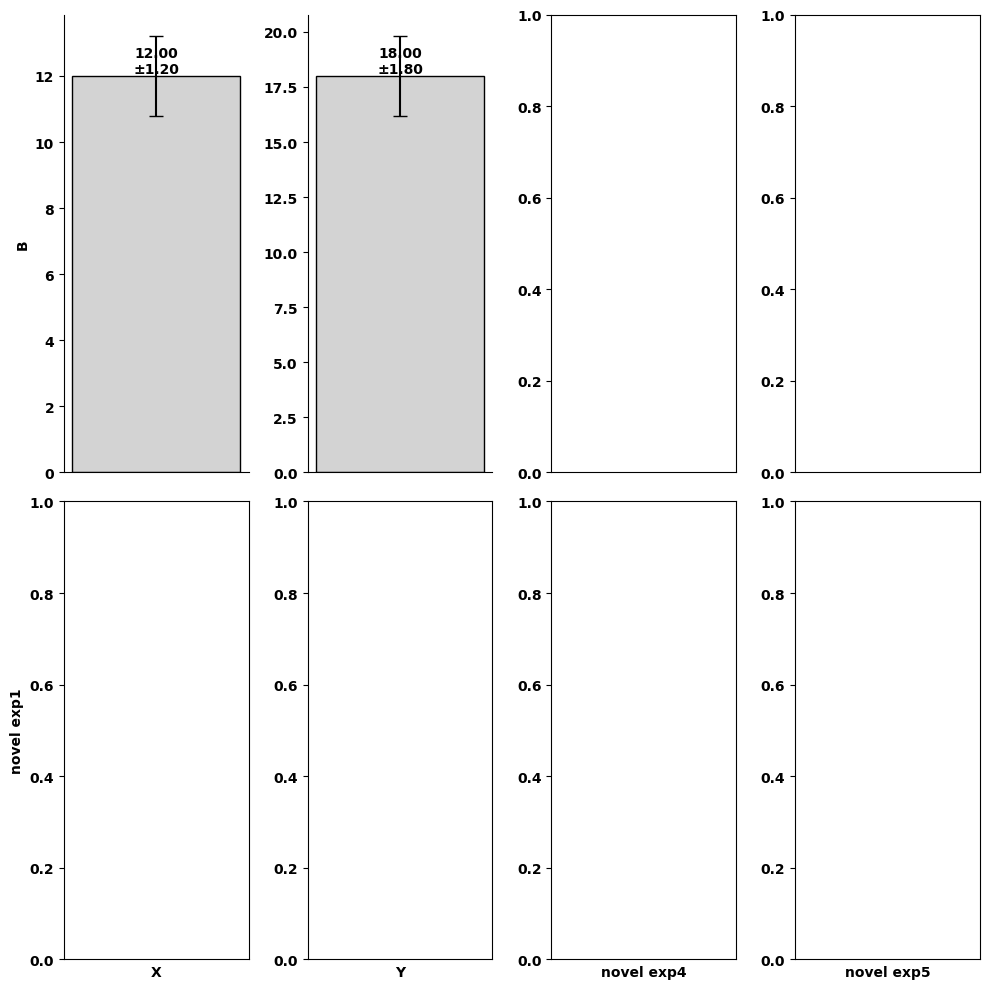

In [85]:
def plot_paired_bar_matrix(pairs, means, sems, figsize=(10,10)):
    """
    Create a matrix of bar plots where each cell shows mean ± SEM for a pair of conditions
    
    Parameters:
    pairs: List of lists, where each sublist contains [row_name, col_name]
    means: Dictionary with (row_name, col_name) tuples as keys and mean values
    sems: Dictionary with (row_name, col_name) tuples as keys and SEM values
    figsize: Tuple for figure size (width, height)
    """
    # Get unique row and column names
    row_names = sorted(list(set([pair[0] for pair in pairs])))
    col_names = sorted(list(set([pair[1] for pair in pairs])))
    
    # Create figure with subplot grid
    fig, axs = plt.subplots(len(row_names), len(col_names), 
                           figsize=figsize, 
                           squeeze=False)
    
    # Iterate through each subplot position
    for i, row in enumerate(row_names):
        for j, col in enumerate(col_names):
            ax = axs[i,j]
            
            # Check if this pair exists in our data
            if (row, col) in means:
                mean = means[(row, col)]
                sem = sems[(row, col)]
                
                # Create bar plot
                ax.bar([0], [mean], yerr=[sem], 
                      capsize=5, color='lightgray', 
                      edgecolor='black')
                
                # Add text for mean ± SEM
                ax.text(0, mean, f'{mean:.2f}\n±{sem:.2f}', 
                       ha='center', va='bottom')
                
                # Remove spines
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                
            # Set labels and limits
            if i == len(row_names)-1:  # Bottom row
                ax.set_xlabel(col)
            if j == 0:  # First column
                ax.set_ylabel(row)
                
            # Remove ticks
            ax.set_xticks([])
    
    plt.tight_layout()
    return fig, axs

# Example usage:
pairs = [['novel exp1', 'novel exp4'], ['novel exp1', 'novel exp5'], ['B', 'X'], ['B', 'Y']]
means = {
    ('A', 'X'): 10, ('A', 'Y'): 15,
    ('B', 'X'): 12, ('B', 'Y'): 18
}
sems = {
    ('A', 'X'): 1, ('A', 'Y'): 1.5,
    ('B', 'X'): 1.2, ('B', 'Y'): 1.8
}

fig, axs = plot_paired_bar_matrix(pairs, means, sems)
plt.show()

In [86]:
def plot_comparison_heatmap(matrix, title, color, diagonal_color, vmin):
    # Create comparison matrix
    # Create figure
    
    # if matrix.index.dtype == 'object':
    #     matrix = matrix.set_index(matrix.columns[0])
    
    # Make sure all data columns are numeric
    matrix = matrix.astype(float)
    plt.figure(figsize=(5, 5))
    n_bins = 100  # Number of color gradients
    cmap = LinearSegmentedColormap.from_list('custom', color, N=n_bins)
    # Create heatmap
    
    sns.heatmap(matrix, 
                annot=True, 
                cmap=cmap,
                fmt='.0f',
                square=True,
                cbar_kws={'label': 'AU Distance', 'shrink': 0.8},
                vmin = vmin)
    if diagonal_color is not None:
        for i in range(len(matrix)):
            plt.plot(i + 0.5, i + 0.5, 'o', color=diagonal_color, markersize=25, zorder =100)
    
    plt.title(title, fontsize = 16)
    plt.tight_layout()
    return plt

<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\lfp_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

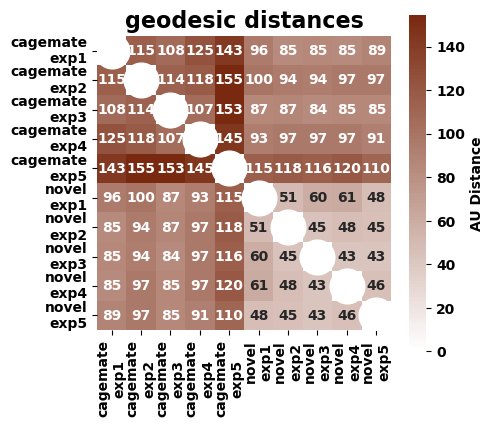

In [87]:
plot_comparison_heatmap(pairwise_distances, title = 'geodesic distances', color = ['white', '#792910'], diagonal_color='white', vmin = 0)

<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\lfp_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

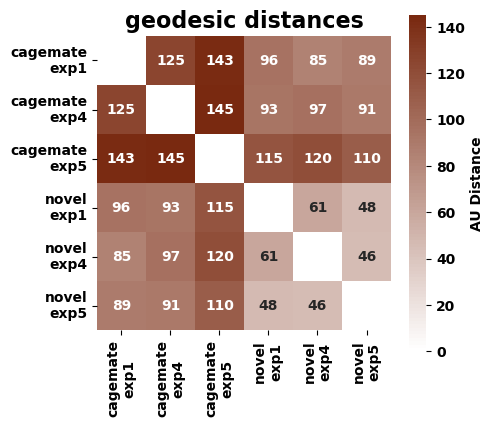

In [88]:
exp_filter = ['exp1', 'exp4', 'exp5']
mask = pairwise_distances.index.str.contains('|'.join(exp_filter))

# Apply mask to both rows and columns
filtered_df = pairwise_distances.loc[mask, mask]
#trimmed_pairwise = pairwise_distances[pairwise_distances[]]
filtered_df
plot_comparison_heatmap(filtered_df, title = 'geodesic distances', color = ['white', '#792910'], diagonal_color='white', vmin = 0)

<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\lfp_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

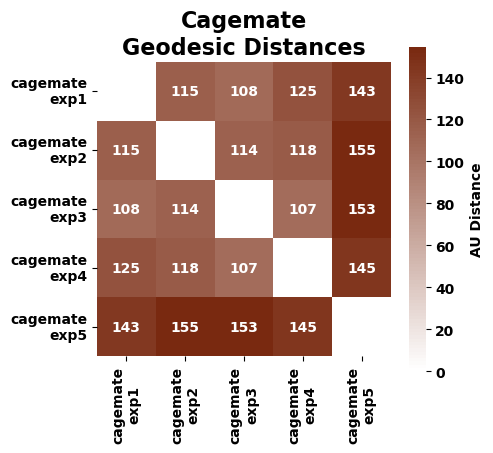

In [89]:
exp_filter = 'cagemate'
cage_mask = pairwise_distances.index.str.contains(exp_filter)

# Apply mask to both rows and columns
cagemate_df = pairwise_distances.loc[cage_mask, cage_mask]
plot_comparison_heatmap(cagemate_df, title = 'Cagemate\nGeodesic Distances', color = ['white', '#792910'], diagonal_color='white', vmin = 0)

<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\lfp_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

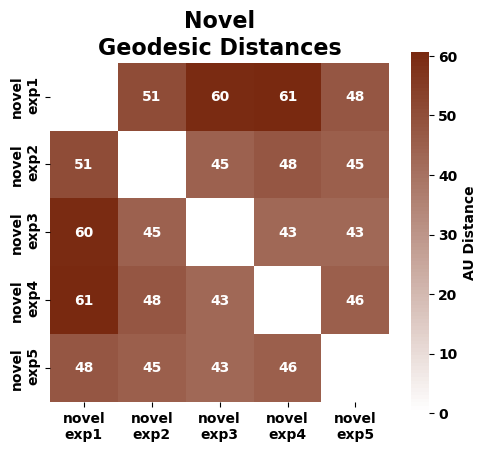

In [90]:
exp_filter = 'novel'
novel_mask = pairwise_distances.index.str.contains(exp_filter)

# Apply mask to both rows and columns
novel_df = pairwise_distances.loc[novel_mask, novel_mask]
plot_comparison_heatmap(novel_df, title = 'Novel\nGeodesic Distances', color = ['white', '#792910'], diagonal_color='white', vmin = 0)

,novel\nexp1,novel\nexp2,novel\nexp3,novel\nexp4,novel\nexp5
cagemate\nexp1,95.782579,84.501876,85.285551,84.830686,88.933045
cagemate\nexp2,99.721176,94.443543,93.621715,96.589299,96.786212
cagemate\nexp3,86.503684,87.046665,84.418714,85.445033,85.382349
cagemate\nexp4,93.412182,96.52405,96.913381,97.176131,91.228082
cagemate\nexp5,114.69742,117.686006,115.795469,120.351249,109.904859


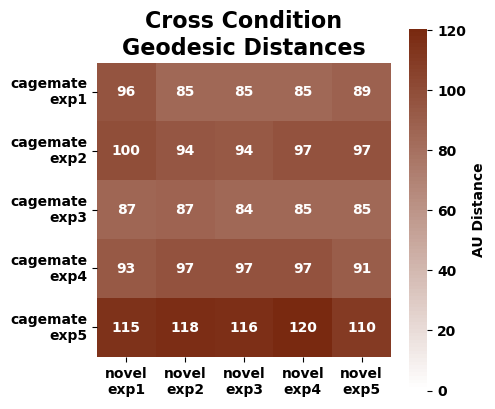

In [94]:


# Apply mask to both rows and columns
cross_df = pairwise_distances.loc[cage_mask, novel_mask]

plot_comparison_heatmap(cross_df, title = 'Cross Condition\nGeodesic Distances', color = ['white', '#792910'], diagonal_color=None, vmin = 0)
cross_df

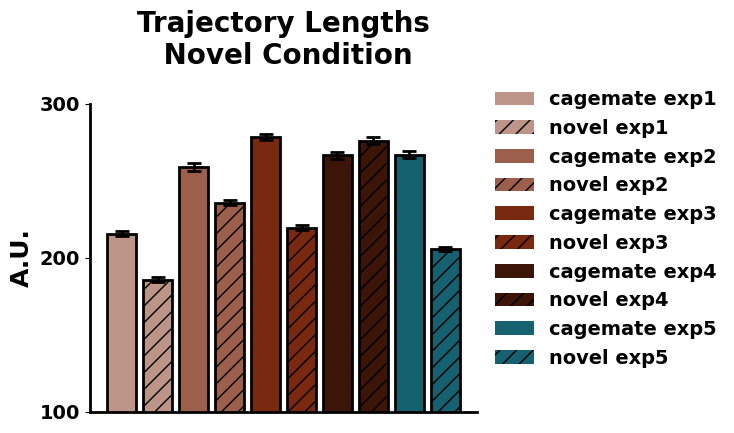

,Comparison,t_statistic,p_value,p_adjusted,significant
0,exp1,10.794980,8.610557e-10,2.583167e-09,True
1,exp2,6.303381,3.743239e-06,7.486478e-06,True
2,exp3,17.824654,9.611122e-14,3.844449e-13,True
3,exp4,-2.430334,2.462157e-02,2.462157e-02,True
4,exp5,19.224214,2.295203e-14,1.147602e-13,True


In [97]:
means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)
means_for_plotting = means[[0,5,1,6,2,7,3,8,4,9]]
sems_for_plotting = sems[[0,5,1,6,2,7,3,8,4,9]]

t_exp1, p_exp1 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,5])
t_exp4, p_exp4 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,8])
t_exp5, p_exp5 = stats.ttest_rel(trajectory_lengths[:,4], trajectory_lengths[:,9])
t_exp2, p_exp2 = stats.ttest_rel(trajectory_lengths[:,1], trajectory_lengths[:,6])
t_exp3, p_exp3 = stats.ttest_rel(trajectory_lengths[:,2], trajectory_lengths[:,7])
p_values = [p_exp1, p_exp2, p_exp3, p_exp4, p_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'],
   't_statistic': [t_exp1, t_exp2, t_exp3, t_exp4, t_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

#Adjust p-values using Holm-Bonferroni

color_id_dict = {'cagemate exp1': hex_2_rgb('#bc9488'), 
                 'novel exp1': hex_2_rgb('#bc9488'), 
                 'cagemate exp2' :hex_2_rgb('#9b5f4c'),
                 'novel exp2' :hex_2_rgb('#9b5f4c'),
                 'cagemate exp3': hex_2_rgb('#792910'),
                 'novel exp3': hex_2_rgb('#792910'),
                'cagemate exp4': hex_2_rgb('#3c1508'),
                 'novel exp4': hex_2_rgb('#3c1508'),
                  'cagemate exp5':  hex_2_rgb('#15616F'),
                  'novel exp5':  hex_2_rgb('#15616F')}
  # Ensures bars don't overlap but aren't too thin
                                # Max width of 0.4 (your original), gets smaller with more bars

# Create evenly spaced x positions based on the number of data points
x = np.arange(len(means_for_plotting))
width = 8 / len(x)
hatches = ['','//']*5
plt.figure(figsize= (.5*len(x),4))           
plt.bar(x, means_for_plotting, yerr = sems_for_plotting,
            color = color_id_dict.values(),
            edgecolor = 'black',
            hatch = hatches,
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = width)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label, hatch=hatch) 
                 for (label, color), hatch in zip(color_id_dict.items(), hatches)]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1.1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.ylim(100,300)
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Novel Condition', fontsize = 20, y = 1.1)
plt.show()

stats_df

In [ ]:
condition_dict

{'cagemate': ['11_cage_p1_merged.rec',
  '12_cage_p1_merged.rec',
  '13_cage_p1_merged.rec',
  '21_cage_p1_merged.rec',
  '22_cage_p1_merged.rec',
  '24_cage_p1_merged.rec',
  '31_cage_p1_merged.rec',
  '32_cage_p1_merged.rec',
  '33_cage_p1_merged.rec',
  '41_cage_p1_merged.rec',
  '44_cage_p1_merged.rec'],
 'novel': ['11_nov_p1_merged.rec',
  '12_nov_p1_merged.rec',
  '13_nov_p1_merged.rec',
  '21_nov_p1_merged.rec',
  '22_nov_p1_merged.rec',
  '24_nov_p1_merged.rec',
  '32_nov_p1_merged.rec',
  '33_nov_p1_merged.rec',
  '41_nov_p1_merged.rec',
  '44_nov_p1_merged.rec']}

In [ ]:
from importlib import reload
import spike.spike_analysis.decoders as decoders
reload(pca_trajectories)
reload(decoders)
events = ['exp1', 'exp4', 'exp5']
#events = ['novel', 'not_novel']
event_length=5
pre_window = 5
post_window=0
min_neurons=5
plot= True
num_fold = 2
no_PCs = 3

decoder_data = decoders.trial_PCA(whole_collection,
                                     no_PCs = no_PCs,
                                     events = events,
                                     event_length=event_length,
                                     pre_window=pre_window,
                                     post_window=post_window,
                                     min_neurons= min_neurons,
                                     condition_dict=condition_dict)

decoder_data.keys()




<class 'dict'>
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


dict_keys(['cagemate exp1', 'cagemate exp4', 'cagemate exp5', 'novel exp1', 'novel exp4', 'novel exp5'])

In [ ]:
keys_wanted = ['cagemate exp1', 'novel exp1']
exp1_data = {k: decoder_data[k] for k in keys_wanted}

exp1_results = decoders.trial_decoder(whole_collection,
                                      num_fold = 5,
                                     no_PCs = no_PCs,
                                     events = keys_wanted,
                                     event_length=event_length,
                                     pre_window=pre_window,
                                     post_window=post_window,
                                     min_neurons= min_neurons, 
                                     decoder_data = exp1_data)

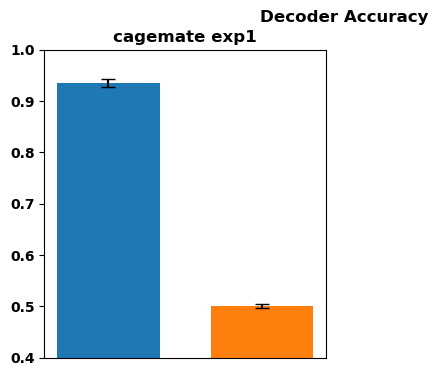

In [ ]:
exp1_results.plot_average()

In [ ]:
keys_wanted = ['cagemate exp4', 'novel exp4']
exp4_data = {k: decoder_data[k] for k in keys_wanted}

exp4_results = decoders.trial_decoder(whole_collection,
                                      num_fold = 5,
                                     no_PCs = no_PCs,
                                     events = keys_wanted,
                                     event_length=event_length,
                                     pre_window=pre_window,
                                     post_window=post_window,
                                     min_neurons= min_neurons, 
                                     decoder_data = exp4_data)

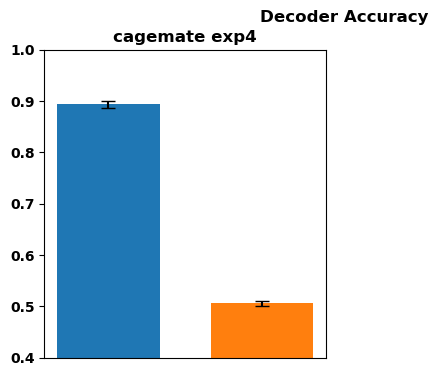

In [ ]:
exp4_results.plot_average()

In [ ]:
print(len(whole_collection.recordings))
for recording in whole_collection.recordings:
    print(recording.name)

21
11_cage_p1_merged.rec
12_cage_p1_merged.rec
13_cage_p1_merged.rec
21_cage_p1_merged.rec
22_cage_p1_merged.rec
24_cage_p1_merged.rec
31_cage_p1_merged.rec
32_cage_p1_merged.rec
33_cage_p1_merged.rec
41_cage_p1_merged.rec
44_cage_p1_merged.rec
11_nov_p1_merged.rec
12_nov_p1_merged.rec
13_nov_p1_merged.rec
21_nov_p1_merged.rec
22_nov_p1_merged.rec
24_nov_p1_merged.rec
32_nov_p1_merged.rec
33_nov_p1_merged.rec
41_nov_p1_merged.rec
44_nov_p1_merged.rec
